In [12]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import pickle
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer
from tensornetwork.tn_keras.layers import Conv2DMPO, DenseMPO
from tf_lassonet.model import LassoNet
from tf_lassonet.path import LassoPath, compute_feature_importances

# Load the dataset

Only the numbers 5 and 6 are selected

In [2]:
BATCH_SIZE = 2048

(ds_train, ds_test), ds_info = tfds.load(
    "mnist",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

def keep_5_and_6(x, y):
    if y == 5 or y == 6:
        return True
    else:
        return False


def to_binary(x, y):
    if y== 5:
        return x, 0
    else:
        return x, 1

def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255.0, label

In [3]:
# Load datasets
ds_train = (
    ds_train.filter(keep_5_and_6)
    .map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(to_binary)
    .cache()
    .shuffle(ds_info.splits["train"].num_examples)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

ds_test = (
    ds_test.filter(keep_5_and_6)
    .map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(to_binary)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(tf.data.experimental.AUTOTUNE)
)

# Create our model

In [30]:
model = Sequential(
    [
        InputLayer((28, 28, 1)),        
        Conv2D(8, (3,3), activation="relu", padding = 'same', name="conv"),
        Flatten(),        
        Dense(2, name="layer4"),
    ]
)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv (Conv2D)               (None, 28, 28, 8)         80        
                                                                 
 flatten_5 (Flatten)         (None, 6272)              0         
                                                                 
 layer4 (Dense)              (None, 2)                 12546     
                                                                 
Total params: 12,626
Trainable params: 12,626
Non-trainable params: 0
_________________________________________________________________


In [5]:
path = LassoPath(
    model, 
    n_iters_init=100, 
    patience_init=3, 
    n_iters_path=10, 
    patience_path=2, 
    M=30,
    path_multiplier=1.05 
)
path.lassonet.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)


In [6]:
h_fc = path.fit(ds_train, val_dataset = ds_test, verbose=True)

0it [00:00, ?it/s]

Epoch 1/100
6/6 [==============================] - 3s 276ms/step - loss: 0.7834 - sparse_categorical_accuracy: 0.4673 - regularization: 51.1609 - number_of_features: 784.0000 - val_loss: 0.6144 - val_sparse_categorical_accuracy: 0.6524
Epoch 2/100
6/6 [==============================] - 1s 89ms/step - loss: 0.5443 - sparse_categorical_accuracy: 0.7360 - regularization: 51.1430 - number_of_features: 784.0000 - val_loss: 0.4347 - val_sparse_categorical_accuracy: 0.8422
Epoch 3/100
6/6 [==============================] - 1s 91ms/step - loss: 0.3919 - sparse_categorical_accuracy: 0.8851 - regularization: 51.1305 - number_of_features: 784.0000 - val_loss: 0.3130 - val_sparse_categorical_accuracy: 0.9211
Epoch 4/100
6/6 [==============================] - 1s 93ms/step - loss: 0.2920 - sparse_categorical_accuracy: 0.9358 - regularization: 51.1223 - number_of_features: 784.0000 - val_loss: 0.2392 - val_sparse_categorical_accuracy: 0.9432
Epoch 5/100
6/6 [==============================] - 1s 101ms

Epoch 36/100
6/6 [==============================] - 1s 98ms/step - loss: 0.0516 - sparse_categorical_accuracy: 0.9829 - regularization: 51.1221 - number_of_features: 784.0000 - val_loss: 0.0544 - val_sparse_categorical_accuracy: 0.9811
Epoch 37/100
6/6 [==============================] - 1s 89ms/step - loss: 0.0507 - sparse_categorical_accuracy: 0.9834 - regularization: 51.1242 - number_of_features: 784.0000 - val_loss: 0.0539 - val_sparse_categorical_accuracy: 0.9811
Epoch 38/100
6/6 [==============================] - 1s 97ms/step - loss: 0.0498 - sparse_categorical_accuracy: 0.9839 - regularization: 51.1260 - number_of_features: 784.0000 - val_loss: 0.0534 - val_sparse_categorical_accuracy: 0.9822
Epoch 39/100
6/6 [==============================] - 1s 96ms/step - loss: 0.0489 - sparse_categorical_accuracy: 0.9840 - regularization: 51.1275 - number_of_features: 784.0000 - val_loss: 0.0530 - val_sparse_categorical_accuracy: 0.9827
Epoch 40/100
6/6 [==============================] - 1s 9

6/6 [==============================] - 1s 106ms/step - loss: 0.0187 - sparse_categorical_accuracy: 0.9953 - regularization: 51.1707 - number_of_features: 784.0000 - val_loss: 0.0375 - val_sparse_categorical_accuracy: 0.9870
Epoch 5/100
6/6 [==============================] - 1s 107ms/step - loss: 0.0184 - sparse_categorical_accuracy: 0.9955 - regularization: 51.1626 - number_of_features: 784.0000 - val_loss: 0.0375 - val_sparse_categorical_accuracy: 0.9876
Epoch 6/100
6/6 [==============================] - 1s 117ms/step - loss: 0.0182 - sparse_categorical_accuracy: 0.9954 - regularization: 51.1537 - number_of_features: 784.0000 - val_loss: 0.0372 - val_sparse_categorical_accuracy: 0.9876
Epoch 7/100
6/6 [==============================] - 1s 103ms/step - loss: 0.0179 - sparse_categorical_accuracy: 0.9954 - regularization: 51.1449 - number_of_features: 784.0000 - val_loss: 0.0371 - val_sparse_categorical_accuracy: 0.9876
Epoch 8/100
6/6 [==============================] - 1s 111ms/step - l

Epoch 25/100
6/6 [==============================] - 1s 104ms/step - loss: 0.0074 - sparse_categorical_accuracy: 0.9986 - regularization: 50.5434 - number_of_features: 784.0000 - val_loss: 0.0305 - val_sparse_categorical_accuracy: 0.9908
Epoch 26/100
6/6 [==============================] - 1s 112ms/step - loss: 0.0073 - sparse_categorical_accuracy: 0.9986 - regularization: 50.5337 - number_of_features: 784.0000 - val_loss: 0.0307 - val_sparse_categorical_accuracy: 0.9908
Epoch 27/100
6/6 [==============================] - 1s 121ms/step - loss: 0.0072 - sparse_categorical_accuracy: 0.9986 - regularization: 50.5238 - number_of_features: 784.0000 - val_loss: 0.0305 - val_sparse_categorical_accuracy: 0.9914
Epoch 28/100
1/1 [==============================] - 0s 136ms/step - loss: 0.0306 - sparse_categorical_accuracy: 0.9914
0.02273587852763012
Epoch 1/100
6/6 [==============================] - 1s 120ms/step - loss: 0.0070 - sparse_categorical_accuracy: 0.9989 - regularization: 50.5039 - numb

1/1 [==============================] - 0s 113ms/step - loss: 0.0294 - sparse_categorical_accuracy: 0.9914
0.02631962138054782
Epoch 1/100
6/6 [==============================] - 1s 106ms/step - loss: 0.0047 - sparse_categorical_accuracy: 0.9996 - regularization: 50.1870 - number_of_features: 784.0000 - val_loss: 0.0294 - val_sparse_categorical_accuracy: 0.9914
Epoch 2/100
6/6 [==============================] - 1s 99ms/step - loss: 0.0046 - sparse_categorical_accuracy: 0.9996 - regularization: 50.1749 - number_of_features: 784.0000 - val_loss: 0.0296 - val_sparse_categorical_accuracy: 0.9914
Epoch 3/100
6/6 [==============================] - 1s 100ms/step - loss: 0.0046 - sparse_categorical_accuracy: 0.9996 - regularization: 50.1629 - number_of_features: 784.0000 - val_loss: 0.0295 - val_sparse_categorical_accuracy: 0.9914
Epoch 4/100
6/6 [==============================] - 1s 96ms/step - loss: 0.0045 - sparse_categorical_accuracy: 0.9996 - regularization: 50.1510 - number_of_features: 78

6/6 [==============================] - 1s 104ms/step - loss: 0.0021 - sparse_categorical_accuracy: 1.0000 - regularization: 49.2975 - number_of_features: 784.0000 - val_loss: 0.0286 - val_sparse_categorical_accuracy: 0.9914
Epoch 4/100
6/6 [==============================] - 1s 109ms/step - loss: 0.0021 - sparse_categorical_accuracy: 1.0000 - regularization: 49.2803 - number_of_features: 784.0000 - val_loss: 0.0286 - val_sparse_categorical_accuracy: 0.9914
Epoch 5/100
1/1 [==============================] - 0s 78ms/step - loss: 0.0285 - sparse_categorical_accuracy: 0.9914
0.038886067887157386
Epoch 1/100
6/6 [==============================] - 1s 108ms/step - loss: 0.0021 - sparse_categorical_accuracy: 1.0000 - regularization: 49.2454 - number_of_features: 784.0000 - val_loss: 0.0285 - val_sparse_categorical_accuracy: 0.9914
Epoch 2/100
6/6 [==============================] - 1s 97ms/step - loss: 0.0020 - sparse_categorical_accuracy: 1.0000 - regularization: 49.2274 - number_of_features: 7

1/1 [==============================] - 0s 99ms/step - loss: 0.0288 - sparse_categorical_accuracy: 0.9908
0.06650837238978817
Epoch 1/100
6/6 [==============================] - 1s 99ms/step - loss: 0.0011 - sparse_categorical_accuracy: 1.0000 - regularization: 47.8126 - number_of_features: 784.0000 - val_loss: 0.0288 - val_sparse_categorical_accuracy: 0.9908
Epoch 2/100
6/6 [==============================] - 1s 94ms/step - loss: 0.0011 - sparse_categorical_accuracy: 1.0000 - regularization: 47.7816 - number_of_features: 784.0000 - val_loss: 0.0288 - val_sparse_categorical_accuracy: 0.9903
Epoch 3/100
6/6 [==============================] - 1s 95ms/step - loss: 0.0011 - sparse_categorical_accuracy: 1.0000 - regularization: 47.7507 - number_of_features: 784.0000 - val_loss: 0.0288 - val_sparse_categorical_accuracy: 0.9908
Epoch 4/100
6/6 [==============================] - 1s 95ms/step - loss: 0.0011 - sparse_categorical_accuracy: 1.0000 - regularization: 47.7197 - number_of_features: 784.0

1/1 [==============================] - 0s 97ms/step - loss: 0.0292 - sparse_categorical_accuracy: 0.9903
0.11943948128963666
Epoch 1/100
6/6 [==============================] - 1s 106ms/step - loss: 6.5757e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 45.2824 - number_of_features: 784.0000 - val_loss: 0.0292 - val_sparse_categorical_accuracy: 0.9903
Epoch 2/100
6/6 [==============================] - 1s 96ms/step - loss: 6.5202e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 45.2271 - number_of_features: 784.0000 - val_loss: 0.0292 - val_sparse_categorical_accuracy: 0.9903
Epoch 3/100
6/6 [==============================] - 1s 96ms/step - loss: 6.4657e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 45.1718 - number_of_features: 784.0000 - val_loss: 0.0292 - val_sparse_categorical_accuracy: 0.9903
Epoch 4/100
6/6 [==============================] - 1s 102ms/step - loss: 6.4179e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 45.1165 - number_

6/6 [==============================] - 1s 96ms/step - loss: 4.1094e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 40.9250 - number_of_features: 784.0000 - val_loss: 0.0297 - val_sparse_categorical_accuracy: 0.9903
Epoch 5/100
6/6 [==============================] - 1s 95ms/step - loss: 4.0840e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 40.8405 - number_of_features: 784.0000 - val_loss: 0.0298 - val_sparse_categorical_accuracy: 0.9903
Epoch 6/100
1/1 [==============================] - 0s 88ms/step - loss: 0.0298 - sparse_categorical_accuracy: 0.9903
0.194554329297774
Epoch 1/100
6/6 [==============================] - 1s 100ms/step - loss: 4.0298e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 40.6688 - number_of_features: 784.0000 - val_loss: 0.0297 - val_sparse_categorical_accuracy: 0.9908
Epoch 2/100
6/6 [==============================] - 1s 95ms/step - loss: 4.0005e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 40.5801 - number_of_

1/1 [==============================] - 0s 106ms/step - loss: 0.0302 - sparse_categorical_accuracy: 0.9908
0.3327539266899047
Epoch 1/100
6/6 [==============================] - 1s 106ms/step - loss: 2.7336e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 34.0118 - number_of_features: 784.0000 - val_loss: 0.0303 - val_sparse_categorical_accuracy: 0.9903
Epoch 2/100
6/6 [==============================] - 1s 93ms/step - loss: 2.7238e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 33.8661 - number_of_features: 784.0000 - val_loss: 0.0303 - val_sparse_categorical_accuracy: 0.9908
Epoch 3/100
6/6 [==============================] - 1s 102ms/step - loss: 2.7011e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 33.7205 - number_of_features: 784.0000 - val_loss: 0.0303 - val_sparse_categorical_accuracy: 0.9908 regularization: 33.7656 - number_of_features: 
Epoch 4/100
6/6 [==============================] - 1s 99ms/step - loss: 2.6916e-04 - sparse_categorical_accur

6/6 [==============================] - 1s 136ms/step - loss: 1.8998e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 23.1764 - number_of_features: 784.0000 - val_loss: 0.0307 - val_sparse_categorical_accuracy: 0.9897
Epoch 4/100
6/6 [==============================] - 1s 131ms/step - loss: 1.8873e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 22.9624 - number_of_features: 784.0000 - val_loss: 0.0308 - val_sparse_categorical_accuracy: 0.9897
Epoch 5/100
6/6 [==============================] - 1s 130ms/step - loss: 1.8767e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 22.7499 - number_of_features: 784.0000 - val_loss: 0.0308 - val_sparse_categorical_accuracy: 0.9897
Epoch 6/100
1/1 [==============================] - 0s 91ms/step - loss: 0.0308 - sparse_categorical_accuracy: 0.9897
0.5975782442547696
Epoch 1/100
6/6 [==============================] - 1s 130ms/step - loss: 1.8558e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 22.3215 - number

6/6 [==============================] - 1s 102ms/step - loss: 1.3595e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 8.6933 - number_of_features: 784.0000 - val_loss: 0.0312 - val_sparse_categorical_accuracy: 0.9897
Epoch 3/100
6/6 [==============================] - 1s 103ms/step - loss: 1.3518e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 8.4622 - number_of_features: 784.0000 - val_loss: 0.0312 - val_sparse_categorical_accuracy: 0.9897
Epoch 4/100
1/1 [==============================] - 0s 85ms/step - loss: 0.0313 - sparse_categorical_accuracy: 0.9897
1.1268229037500317
Epoch 1/100
6/6 [==============================] - 1s 103ms/step - loss: 1.3386e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 8.0049 - number_of_features: 784.0000 - val_loss: 0.0313 - val_sparse_categorical_accuracy: 0.9897
Epoch 2/100
6/6 [==============================] - 1s 92ms/step - loss: 1.3312e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 7.7743 - number_of_f

1/1 [==============================] - 0s 121ms/step - loss: 0.0318 - sparse_categorical_accuracy: 0.9903
2.0236120400061197
Epoch 1/100
6/6 [==============================] - 1s 114ms/step - loss: 9.8681e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.4633 - number_of_features: 784.0000 - val_loss: 0.0318 - val_sparse_categorical_accuracy: 0.9903
Epoch 2/100
6/6 [==============================] - 1s 104ms/step - loss: 9.8256e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.4626 - number_of_features: 784.0000 - val_loss: 0.0319 - val_sparse_categorical_accuracy: 0.9903
Epoch 3/100
6/6 [==============================] - 1s 108ms/step - loss: 9.7781e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.4622 - number_of_features: 784.0000 - val_loss: 0.0318 - val_sparse_categorical_accuracy: 0.9903
Epoch 4/100
1/1 [==============================] - 0s 84ms/step - loss: 0.0319 - sparse_categorical_accuracy: 0.9903
2.1247926420064256
Epoch 1/100
6/6 [=====

6/6 [==============================] - 1s 99ms/step - loss: 7.3354e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.4301 - number_of_features: 784.0000 - val_loss: 0.0324 - val_sparse_categorical_accuracy: 0.9903
Epoch 4/100
1/1 [==============================] - 0s 100ms/step - loss: 0.0324 - sparse_categorical_accuracy: 0.9903
3.6341164834595365
Epoch 1/100
6/6 [==============================] - 1s 96ms/step - loss: 7.2710e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.4287 - number_of_features: 784.0000 - val_loss: 0.0324 - val_sparse_categorical_accuracy: 0.9903
Epoch 2/100
6/6 [==============================] - 1s 102ms/step - loss: 7.2375e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.4280 - number_of_features: 784.0000 - val_loss: 0.0324 - val_sparse_categorical_accuracy: 0.9903
Epoch 3/100
6/6 [==============================] - 1s 98ms/step - loss: 7.2049e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.4273 - number_of_fe

Epoch 2/100
6/6 [==============================] - 1s 118ms/step - loss: 6.3641e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.4053 - number_of_features: 784.0000 - val_loss: 0.0326 - val_sparse_categorical_accuracy: 0.9903
Epoch 3/100
6/6 [==============================] - 1s 122ms/step - loss: 6.3338e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.4044 - number_of_features: 784.0000 - val_loss: 0.0326 - val_sparse_categorical_accuracy: 0.9903
Epoch 4/100
6/6 [==============================] - 1s 116ms/step - loss: 6.3056e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.4035 - number_of_features: 784.0000 - val_loss: 0.0327 - val_sparse_categorical_accuracy: 0.9903
Epoch 5/100
1/1 [==============================] - 0s 91ms/step - loss: 0.0327 - sparse_categorical_accuracy: 0.9903
5.11356683985796
Epoch 1/100
6/6 [==============================] - 1s 120ms/step - loss: 6.2488e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.4016 - 

1/1 [==============================] - 0s 98ms/step - loss: 0.0332 - sparse_categorical_accuracy: 0.9903
8.745934626567534
Epoch 1/100
6/6 [==============================] - 1s 101ms/step - loss: 4.8160e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.3373 - number_of_features: 784.0000 - val_loss: 0.0332 - val_sparse_categorical_accuracy: 0.9903
Epoch 2/100
6/6 [==============================] - 1s 97ms/step - loss: 4.7994e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.3360 - number_of_features: 784.0000 - val_loss: 0.0332 - val_sparse_categorical_accuracy: 0.9903
Epoch 3/100
6/6 [==============================] - 1s 95ms/step - loss: 4.7720e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.3347 - number_of_features: 784.0000 - val_loss: 0.0333 - val_sparse_categorical_accuracy: 0.9903
Epoch 4/100
6/6 [==============================] - 1s 100ms/step - loss: 4.7610e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.3335 - number_of_fea

Epoch 2/100
6/6 [==============================] - 1s 118ms/step - loss: 4.2440e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.2966 - number_of_features: 784.0000 - val_loss: 0.0335 - val_sparse_categorical_accuracy: 0.9903
Epoch 3/100
6/6 [==============================] - 1s 128ms/step - loss: 4.2269e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.2952 - number_of_features: 784.0000 - val_loss: 0.0335 - val_sparse_categorical_accuracy: 0.9903
Epoch 4/100
1/1 [==============================] - 0s 85ms/step - loss: 0.0335 - sparse_categorical_accuracy: 0.9903
12.306408309567113
Epoch 1/100
6/6 [==============================] - 1s 123ms/step - loss: 4.1924e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.2922 - number_of_features: 784.0000 - val_loss: 0.0335 - val_sparse_categorical_accuracy: 0.9903
Epoch 2/100
6/6 [==============================] - 1s 120ms/step - loss: 4.1740e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.2907 

6/6 [==============================] - 1s 104ms/step - loss: 3.3311e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.2011 - number_of_features: 784.0000 - val_loss: 0.0341 - val_sparse_categorical_accuracy: 0.9903
Epoch 3/100
6/6 [==============================] - 1s 106ms/step - loss: 3.3242e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.1993 - number_of_features: 784.0000 - val_loss: 0.0340 - val_sparse_categorical_accuracy: 0.9903
Epoch 4/100
6/6 [==============================] - 1s 98ms/step - loss: 3.3051e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.1976 - number_of_features: 784.0000 - val_loss: 0.0341 - val_sparse_categorical_accuracy: 0.9903
Epoch 5/100
6/6 [==============================] - 1s 102ms/step - loss: 3.2920e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.1959 - number_of_features: 784.0000 - val_loss: 0.0341 - val_sparse_categorical_accuracy: 0.9903
Epoch 6/100
1/1 [==============================] - 0s 77m

1/1 [==============================] - 0s 98ms/step - loss: 0.0346 - sparse_categorical_accuracy: 0.9903
37.79942547285975
Epoch 1/100
6/6 [==============================] - 1s 108ms/step - loss: 2.6507e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.0954 - number_of_features: 784.0000 - val_loss: 0.0346 - val_sparse_categorical_accuracy: 0.9903ation: 2.0957 - number_of_features: 784.00
Epoch 2/100
6/6 [==============================] - 1s 115ms/step - loss: 2.6437e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.0937 - number_of_features: 784.0000 - val_loss: 0.0346 - val_sparse_categorical_accuracy: 0.9903
Epoch 3/100
6/6 [==============================] - 1s 109ms/step - loss: 2.6309e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.0920 - number_of_features: 784.0000 - val_loss: 0.0347 - val_sparse_categorical_accuracy: 0.9903- regularization: 2.0924 - number_of_features: 784.0
Epoch 4/100
1/1 [==============================] - 0s 94ms/step - 

1/1 [==============================] - 0s 90ms/step - loss: 0.0349 - sparse_categorical_accuracy: 0.9903
50.65484529430894
Epoch 1/100
6/6 [==============================] - 1s 121ms/step - loss: 2.3922e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.0418 - number_of_features: 784.0000 - val_loss: 0.0349 - val_sparse_categorical_accuracy: 0.9903
Epoch 2/100
6/6 [==============================] - 1s 106ms/step - loss: 2.3844e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.0400 - number_of_features: 784.0000 - val_loss: 0.0349 - val_sparse_categorical_accuracy: 0.9903
Epoch 3/100
6/6 [==============================] - 1s 106ms/step - loss: 2.3778e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.0383 - number_of_features: 784.0000 - val_loss: 0.0349 - val_sparse_categorical_accuracy: 0.9903
Epoch 4/100
6/6 [==============================] - 1s 102ms/step - loss: 2.3719e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.0365 - number_of_f

1/1 [==============================] - 0s 71ms/step - loss: 0.0354 - sparse_categorical_accuracy: 0.9903
90.96882436545707
Epoch 1/100
6/6 [==============================] - 1s 133ms/step - loss: 1.9985e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.9323 - number_of_features: 784.0000 - val_loss: 0.0355 - val_sparse_categorical_accuracy: 0.9903
Epoch 2/100
6/6 [==============================] - 1s 117ms/step - loss: 1.9936e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.9303 - number_of_features: 784.0000 - val_loss: 0.0355 - val_sparse_categorical_accuracy: 0.9903
Epoch 3/100
6/6 [==============================] - 1s 121ms/step - loss: 1.9882e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.9284 - number_of_features: 784.0000 - val_loss: 0.0355 - val_sparse_categorical_accuracy: 0.9903
Epoch 4/100
1/1 [==============================] - 0s 71ms/step - loss: 0.0355 - sparse_categorical_accuracy: 0.9903
95.51726558372992
Epoch 1/100
6/6 [========

Epoch 3/100
6/6 [==============================] - 1s 96ms/step - loss: 1.7581e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.8098 - number_of_features: 784.0000 - val_loss: 0.0360 - val_sparse_categorical_accuracy: 0.9903
Epoch 4/100
6/6 [==============================] - 1s 101ms/step - loss: 1.7558e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.8078 - number_of_features: 784.0000 - val_loss: 0.0360 - val_sparse_categorical_accuracy: 0.9903
Epoch 5/100
6/6 [==============================] - 1s 101ms/step - loss: 1.7507e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.8058 - number_of_features: 784.0000 - val_loss: 0.0360 - val_sparse_categorical_accuracy: 0.9903
Epoch 6/100
6/6 [==============================] - 1s 106ms/step - loss: 1.7499e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.8039 - number_of_features: 784.0000 - val_loss: 0.0361 - val_sparse_categorical_accuracy: 0.9903
Epoch 7/100
1/1 [============================

Epoch 4/100
6/6 [==============================] - 1s 100ms/step - loss: 1.6824e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.7453 - number_of_features: 784.0000 - val_loss: 0.0363 - val_sparse_categorical_accuracy: 0.9903
Epoch 5/100
1/1 [==============================] - 0s 78ms/step - loss: 0.0363 - sparse_categorical_accuracy: 0.9903
208.5022117944526
Epoch 1/100
6/6 [==============================] - 1s 114ms/step - loss: 1.6769e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.7413 - number_of_features: 784.0000 - val_loss: 0.0363 - val_sparse_categorical_accuracy: 0.9903
Epoch 2/100
6/6 [==============================] - 1s 110ms/step - loss: 1.6760e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.7392 - number_of_features: 784.0000 - val_loss: 0.0363 - val_sparse_categorical_accuracy: 0.9903
Epoch 3/100
6/6 [==============================] - 1s 114ms/step - loss: 1.6754e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.7372 -

6/6 [==============================] - 1s 105ms/step - loss: 1.6137e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.6177 - number_of_features: 784.0000 - val_loss: 0.0364 - val_sparse_categorical_accuracy: 0.9903
Epoch 2/100
6/6 [==============================] - 1s 103ms/step - loss: 1.6145e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.6155 - number_of_features: 784.0000 - val_loss: 0.0364 - val_sparse_categorical_accuracy: 0.9903
Epoch 3/100
6/6 [==============================] - 1s 109ms/step - loss: 1.6121e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.6134 - number_of_features: 784.0000 - val_loss: 0.0364 - val_sparse_categorical_accuracy: 0.9903
Epoch 4/100
6/6 [==============================] - 1s 117ms/step - loss: 1.6131e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.6113 - number_of_features: 784.0000 - val_loss: 0.0365 - val_sparse_categorical_accuracy: 0.9903
Epoch 5/100
1/1 [==============================] - 0s 89

6/6 [==============================] - 1s 110ms/step - loss: 1.6124e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.5499 - number_of_features: 784.0000 - val_loss: 0.0363 - val_sparse_categorical_accuracy: 0.9903
Epoch 4/100
6/6 [==============================] - 1s 98ms/step - loss: 1.6145e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.5478 - number_of_features: 784.0000 - val_loss: 0.0364 - val_sparse_categorical_accuracy: 0.9903
Epoch 5/100
6/6 [==============================] - 1s 107ms/step - loss: 1.6134e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.5457 - number_of_features: 784.0000 - val_loss: 0.0364 - val_sparse_categorical_accuracy: 0.9903
Epoch 6/100
6/6 [==============================] - 1s 107ms/step - loss: 1.6129e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.5437 - number_of_features: 784.0000 - val_loss: 0.0363 - val_sparse_categorical_accuracy: 0.9903
Epoch 7/100
6/6 [==============================] - 1s 108

Epoch 6/100
6/6 [==============================] - 1s 99ms/step - loss: 1.6025e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.4222 - number_of_features: 784.0000 - val_loss: 0.0360 - val_sparse_categorical_accuracy: 0.9903
Epoch 7/100
6/6 [==============================] - 1s 101ms/step - loss: 1.6043e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.4203 - number_of_features: 784.0000 - val_loss: 0.0360 - val_sparse_categorical_accuracy: 0.9903
Epoch 8/100
6/6 [==============================] - 1s 106ms/step - loss: 1.6015e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.4183 - number_of_features: 784.0000 - val_loss: 0.0360 - val_sparse_categorical_accuracy: 0.9903
Epoch 9/100
1/1 [==============================] - 0s 118ms/step - loss: 0.0361 - sparse_categorical_accuracy: 0.9908
580.8793620753453
Epoch 1/100
6/6 [==============================] - 1s 120ms/step - loss: 1.6024e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.4145 -

Epoch 2/100
6/6 [==============================] - 1s 123ms/step - loss: 1.6251e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.3566 - number_of_features: 784.0000 - val_loss: 0.0357 - val_sparse_categorical_accuracy: 0.9908
Epoch 3/100
6/6 [==============================] - 1s 135ms/step - loss: 1.6301e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.3545 - number_of_features: 784.0000 - val_loss: 0.0356 - val_sparse_categorical_accuracy: 0.9908
Epoch 4/100
6/6 [==============================] - 1s 117ms/step - loss: 1.6289e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.3524 - number_of_features: 784.0000 - val_loss: 0.0356 - val_sparse_categorical_accuracy: 0.9908
Epoch 5/100
6/6 [==============================] - 1s 129ms/step - loss: 1.6309e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.3503 - number_of_features: 784.0000 - val_loss: 0.0357 - val_sparse_categorical_accuracy: 0.9903
Epoch 6/100
1/1 [===========================

6/6 [==============================] - 1s 103ms/step - loss: 1.7557e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.2137 - number_of_features: 784.0000 - val_loss: 0.0348 - val_sparse_categorical_accuracy: 0.9908
Epoch 11/100
6/6 [==============================] - 1s 106ms/step - loss: 1.7621e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.2114 - number_of_features: 784.0000 - val_loss: 0.0348 - val_sparse_categorical_accuracy: 0.9908
Epoch 12/100
6/6 [==============================] - 1s 103ms/step - loss: 1.7624e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.2091 - number_of_features: 784.0000 - val_loss: 0.0348 - val_sparse_categorical_accuracy: 0.9908
Epoch 13/100
6/6 [==============================] - 1s 106ms/step - loss: 1.7671e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.2068 - number_of_features: 784.0000 - val_loss: 0.0348 - val_sparse_categorical_accuracy: 0.9908
Epoch 14/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 85ms/step - loss: 0.0338 - sparse_categorical_accuracy: 0.9903
1541.2458783602692
Epoch 1/100
6/6 [==============================] - 1s 120ms/step - loss: 1.9748e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.0554 - number_of_features: 784.0000 - val_loss: 0.0337 - val_sparse_categorical_accuracy: 0.9903
Epoch 2/100
6/6 [==============================] - 1s 182ms/step - loss: 1.9722e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.0528 - number_of_features: 784.0000 - val_loss: 0.0339 - val_sparse_categorical_accuracy: 0.9903
Epoch 3/100
6/6 [==============================] - 1s 177ms/step - loss: 1.9789e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.0502 - number_of_features: 784.0000 - val_loss: 0.0338 - val_sparse_categorical_accuracy: 0.9897
Epoch 4/100
6/6 [==============================] - 1s 173ms/step - loss: 1.9839e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.0477 - number_of_

Epoch 6/100
6/6 [==============================] - 1s 105ms/step - loss: 2.3036e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.8817 - number_of_features: 784.0000 - val_loss: 0.0325 - val_sparse_categorical_accuracy: 0.9903
Epoch 7/100
1/1 [==============================] - 0s 83ms/step - loss: 0.0325 - sparse_categorical_accuracy: 0.9903
2277.122113200836
Epoch 1/100
6/6 [==============================] - 1s 107ms/step - loss: 2.3233e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.8759 - number_of_features: 784.0000 - val_loss: 0.0326 - val_sparse_categorical_accuracy: 0.9897
Epoch 2/100
6/6 [==============================] - 1s 98ms/step - loss: 2.3231e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.8730 - number_of_features: 784.0000 - val_loss: 0.0323 - val_sparse_categorical_accuracy: 0.9903
Epoch 3/100
6/6 [==============================] - 1s 102ms/step - loss: 2.3451e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.8700 - 

Epoch 16/100
6/6 [==============================] - 1s 115ms/step - loss: 2.5797e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.7839 - number_of_features: 784.0000 - val_loss: 0.0317 - val_sparse_categorical_accuracy: 0.9903
Epoch 17/100
6/6 [==============================] - 1s 107ms/step - loss: 2.5944e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.7810 - number_of_features: 784.0000 - val_loss: 0.0316 - val_sparse_categorical_accuracy: 0.9903
Epoch 18/100
6/6 [==============================] - 1s 103ms/step - loss: 2.5797e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.7781 - number_of_features: 784.0000 - val_loss: 0.0319 - val_sparse_categorical_accuracy: 0.9903
Epoch 19/100
6/6 [==============================] - 1s 109ms/step - loss: 2.5909e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.7753 - number_of_features: 784.0000 - val_loss: 0.0317 - val_sparse_categorical_accuracy: 0.9903
Epoch 20/100
1/1 [======================

6/6 [==============================] - 1s 96ms/step - loss: 3.2987e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.5851 - number_of_features: 784.0000 - val_loss: 0.0305 - val_sparse_categorical_accuracy: 0.9903
Epoch 3/100
6/6 [==============================] - 1s 103ms/step - loss: 3.2934e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.5817 - number_of_features: 784.0000 - val_loss: 0.0308 - val_sparse_categorical_accuracy: 0.9903
Epoch 4/100
6/6 [==============================] - 1s 102ms/step - loss: 3.3318e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.5784 - number_of_features: 784.0000 - val_loss: 0.0306 - val_sparse_categorical_accuracy: 0.9903
Epoch 5/100
1/1 [==============================] - 0s 77ms/step - loss: 0.0308 - sparse_categorical_accuracy: 0.9903
3894.6515734443833
Epoch 1/100
6/6 [==============================] - 1s 107ms/step - loss: 3.4129e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.5715 - number_of_f

Epoch 3/100
6/6 [==============================] - 1s 160ms/step - loss: 4.0192e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.4717 - number_of_features: 784.0000 - val_loss: 0.0298 - val_sparse_categorical_accuracy: 0.9903
Epoch 4/100
6/6 [==============================] - 1s 163ms/step - loss: 4.0571e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.4683 - number_of_features: 784.0000 - val_loss: 0.0299 - val_sparse_categorical_accuracy: 0.9903
Epoch 5/100
6/6 [==============================] - 1s 160ms/step - loss: 4.0864e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.4648 - number_of_features: 784.0000 - val_loss: 0.0296 - val_sparse_categorical_accuracy: 0.9903
Epoch 6/100
6/6 [==============================] - 1s 160ms/step - loss: 4.0883e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.4614 - number_of_features: 784.0000 - val_loss: 0.0300 - val_sparse_categorical_accuracy: 0.9903
Epoch 7/100
6/6 [===========================

Epoch 7/100
6/6 [==============================] - 1s 97ms/step - loss: 7.2778e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.2389 - number_of_features: 784.0000 - val_loss: 0.0287 - val_sparse_categorical_accuracy: 0.9908
Epoch 8/100
6/6 [==============================] - 1s 101ms/step - loss: 7.4505e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.2352 - number_of_features: 784.0000 - val_loss: 0.0282 - val_sparse_categorical_accuracy: 0.9908
Epoch 9/100
6/6 [==============================] - 1s 99ms/step - loss: 7.4672e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.2314 - number_of_features: 784.0000 - val_loss: 0.0283 - val_sparse_categorical_accuracy: 0.9908
Epoch 10/100
6/6 [==============================] - 1s 102ms/step - loss: 7.5315e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.2277 - number_of_features: 784.0000 - val_loss: 0.0283 - val_sparse_categorical_accuracy: 0.9908
Epoch 11/100
1/1 [===========================

6/6 [==============================] - 1s 102ms/step - loss: 2.5286e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 0.0903 - number_of_features: 468.1429 - val_loss: 0.0287 - val_sparse_categorical_accuracy: 0.9903
Epoch 4/100
6/6 [==============================] - 1s 101ms/step - loss: 2.4661e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 0.0889 - number_of_features: 463.1429 - val_loss: 0.0285 - val_sparse_categorical_accuracy: 0.9908
Epoch 5/100
6/6 [==============================] - 1s 100ms/step - loss: 2.5498e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 0.0877 - number_of_features: 465.8571 - val_loss: 0.0278 - val_sparse_categorical_accuracy: 0.9914
Epoch 6/100
6/6 [==============================] - 1s 95ms/step - loss: 2.4421e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 0.0863 - number_of_features: 450.1429 - val_loss: 0.0282 - val_sparse_categorical_accuracy: 0.9919
Epoch 7/100
6/6 [==============================] - 1s 106

6/6 [==============================] - 1s 106ms/step - loss: 0.0029 - sparse_categorical_accuracy: 1.0000 - regularization: 0.0340 - number_of_features: 391.2857 - val_loss: 0.0301 - val_sparse_categorical_accuracy: 0.9914
Epoch 4/100
6/6 [==============================] - 1s 105ms/step - loss: 0.0032 - sparse_categorical_accuracy: 0.9998 - regularization: 0.0336 - number_of_features: 415.0000 - val_loss: 0.0281 - val_sparse_categorical_accuracy: 0.9908
Epoch 5/100
6/6 [==============================] - 1s 106ms/step - loss: 0.0032 - sparse_categorical_accuracy: 1.0000 - regularization: 0.0331 - number_of_features: 396.1429 - val_loss: 0.0298 - val_sparse_categorical_accuracy: 0.9908
Epoch 6/100
6/6 [==============================] - 1s 102ms/step - loss: 0.0035 - sparse_categorical_accuracy: 0.9999 - regularization: 0.0326 - number_of_features: 424.0000 - val_loss: 0.0303 - val_sparse_categorical_accuracy: 0.9897
Epoch 7/100
1/1 [==============================] - 0s 84ms/step - loss: 

1/1 [==============================] - 0s 68ms/step - loss: 0.0469 - sparse_categorical_accuracy: 0.9865
30228.679183964472
Epoch 1/100
6/6 [==============================] - 1s 181ms/step - loss: 0.0372 - sparse_categorical_accuracy: 0.9907 - regularization: 0.0098 - number_of_features: 271.1429 - val_loss: 0.0519 - val_sparse_categorical_accuracy: 0.9832
Epoch 2/100
6/6 [==============================] - 1s 170ms/step - loss: 0.0366 - sparse_categorical_accuracy: 0.9892 - regularization: 0.0096 - number_of_features: 265.4286 - val_loss: 0.0502 - val_sparse_categorical_accuracy: 0.9832gularization: 0.0097 - number_of_features: 272.2
Epoch 3/100
6/6 [==============================] - 1s 174ms/step - loss: 0.0379 - sparse_categorical_accuracy: 0.9893 - regularization: 0.0094 - number_of_features: 268.5714 - val_loss: 0.0525 - val_sparse_categorical_accuracy: 0.9838
Epoch 4/100
6/6 [==============================] - 1s 171ms/step - loss: 0.0393 - sparse_categorical_accuracy: 0.9887 - reg

6/6 [==============================] - 1s 108ms/step - loss: 0.0823 - sparse_categorical_accuracy: 0.9758 - regularization: 0.0037 - number_of_features: 155.5714 - val_loss: 0.0975 - val_sparse_categorical_accuracy: 0.9670
Epoch 4/100
1/1 [==============================] - 0s 90ms/step - loss: 0.0976 - sparse_categorical_accuracy: 0.9697
49239.33309733885
Epoch 1/100
6/6 [==============================] - 1s 108ms/step - loss: 0.0875 - sparse_categorical_accuracy: 0.9765 - regularization: 0.0036 - number_of_features: 155.4286 - val_loss: 0.0972 - val_sparse_categorical_accuracy: 0.9649
Epoch 2/100
6/6 [==============================] - 1s 102ms/step - loss: 0.0881 - sparse_categorical_accuracy: 0.9749 - regularization: 0.0036 - number_of_features: 153.7143 - val_loss: 0.1029 - val_sparse_categorical_accuracy: 0.9638
Epoch 3/100
6/6 [==============================] - 1s 104ms/step - loss: 0.0860 - sparse_categorical_accuracy: 0.9754 - regularization: 0.0036 - number_of_features: 155.571

Epoch 5/100
1/1 [==============================] - 0s 81ms/step - loss: 0.1174 - sparse_categorical_accuracy: 0.9643
65985.4156310261
Epoch 1/100
6/6 [==============================] - 1s 114ms/step - loss: 0.1234 - sparse_categorical_accuracy: 0.9706 - regularization: 0.0023 - number_of_features: 111.5714 - val_loss: 0.1225 - val_sparse_categorical_accuracy: 0.9622
Epoch 2/100
6/6 [==============================] - 1s 110ms/step - loss: 0.1185 - sparse_categorical_accuracy: 0.9705 - regularization: 0.0023 - number_of_features: 109.2857 - val_loss: 0.1322 - val_sparse_categorical_accuracy: 0.9595
Epoch 3/100
6/6 [==============================] - 1s 105ms/step - loss: 0.1194 - sparse_categorical_accuracy: 0.9698 - regularization: 0.0023 - number_of_features: 115.0000 - val_loss: 0.1331 - val_sparse_categorical_accuracy: 0.9595
Epoch 4/100
1/1 [==============================] - 0s 94ms/step - loss: 0.1297 - sparse_categorical_accuracy: 0.9622
69284.68641257742
Epoch 1/100
6/6 [=========

Epoch 3/100
6/6 [==============================] - 1s 139ms/step - loss: 0.2525 - sparse_categorical_accuracy: 0.9525 - regularization: 0.0015 - number_of_features: 54.8571 - val_loss: 0.2638 - val_sparse_categorical_accuracy: 0.9422
Epoch 4/100
1/1 [==============================] - 0s 76ms/step - loss: 0.2684 - sparse_categorical_accuracy: 0.9400
97490.51153474346
Epoch 1/100
6/6 [==============================] - 1s 137ms/step - loss: 0.3050 - sparse_categorical_accuracy: 0.9429 - regularization: 0.0014 - number_of_features: 48.1429 - val_loss: 0.2795 - val_sparse_categorical_accuracy: 0.9378
Epoch 2/100
6/6 [==============================] - 1s 124ms/step - loss: 0.2920 - sparse_categorical_accuracy: 0.9391 - regularization: 0.0014 - number_of_features: 44.7143 - val_loss: 0.3059 - val_sparse_categorical_accuracy: 0.9222
Epoch 3/100
6/6 [==============================] - 1s 135ms/step - loss: 0.3096 - sparse_categorical_accuracy: 0.9413 - regularization: 0.0014 - number_of_features

In [29]:
model_tn = Sequential(
    [
        InputLayer((28, 28, 1)),        
        Conv2DMPO(8, (3,3), num_nodes = 3, bond_dim = 2, activation="relu", name="conv"),
        Flatten(),        
        Dense(2, name="layer4"),
    ]
)
model_tn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv (Conv2DMPO)            (None, 28, 28, 8)         40        
                                                                 
 flatten_4 (Flatten)         (None, 6272)              0         
                                                                 
 layer4 (Dense)              (None, 2)                 12546     
                                                                 
Total params: 12,586
Trainable params: 12,586
Non-trainable params: 0
_________________________________________________________________


In [8]:
path_tn = LassoPath(
    model_tn, 
    n_iters_init=100, 
    patience_init=3, 
    n_iters_path=10, 
    patience_path=2, 
    M=30,
    path_multiplier=1.05 
)
path_tn.lassonet.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [9]:
h_tn = path_tn.fit(ds_train, val_dataset = ds_test, verbose=True)

0it [00:00, ?it/s]

Epoch 1/100
6/6 [==============================] - 4s 225ms/step - loss: 0.7449 - sparse_categorical_accuracy: 0.4947 - regularization: 52.6151 - number_of_features: 784.0000 - val_loss: 0.6191 - val_sparse_categorical_accuracy: 0.6730
Epoch 2/100
6/6 [==============================] - 1s 107ms/step - loss: 0.5474 - sparse_categorical_accuracy: 0.7691 - regularization: 52.6030 - number_of_features: 784.0000 - val_loss: 0.4557 - val_sparse_categorical_accuracy: 0.8600
Epoch 3/100
6/6 [==============================] - 1s 107ms/step - loss: 0.4092 - sparse_categorical_accuracy: 0.9010 - regularization: 52.5910 - number_of_features: 784.0000 - val_loss: 0.3367 - val_sparse_categorical_accuracy: 0.9249
Epoch 4/100
6/6 [==============================] - 1s 105ms/step - loss: 0.3104 - sparse_categorical_accuracy: 0.9444 - regularization: 52.5815 - number_of_features: 784.0000 - val_loss: 0.2575 - val_sparse_categorical_accuracy: 0.9443
Epoch 5/100
6/6 [==============================] - 1s 10

6/6 [==============================] - 1s 102ms/step - loss: 0.0482 - sparse_categorical_accuracy: 0.9843 - regularization: 52.5630 - number_of_features: 784.0000 - val_loss: 0.0527 - val_sparse_categorical_accuracy: 0.9838
Epoch 36/100
6/6 [==============================] - 1s 102ms/step - loss: 0.0472 - sparse_categorical_accuracy: 0.9848 - regularization: 52.5633 - number_of_features: 784.0000 - val_loss: 0.0522 - val_sparse_categorical_accuracy: 0.9838
Epoch 37/100
6/6 [==============================] - 1s 110ms/step - loss: 0.0462 - sparse_categorical_accuracy: 0.9854 - regularization: 52.5634 - number_of_features: 784.0000 - val_loss: 0.0517 - val_sparse_categorical_accuracy: 0.9838
Epoch 38/100
6/6 [==============================] - 1s 104ms/step - loss: 0.0453 - sparse_categorical_accuracy: 0.9856 - regularization: 52.5634 - number_of_features: 784.0000 - val_loss: 0.0512 - val_sparse_categorical_accuracy: 0.9838
Epoch 39/100
6/6 [==============================] - 1s 105ms/step

6/6 [==============================] - 1s 129ms/step - loss: 0.0259 - sparse_categorical_accuracy: 0.9921 - regularization: 52.5701 - number_of_features: 784.0000 - val_loss: 0.0422 - val_sparse_categorical_accuracy: 0.9843
Epoch 70/100
6/6 [==============================] - 1s 127ms/step - loss: 0.0255 - sparse_categorical_accuracy: 0.9921 - regularization: 52.5706 - number_of_features: 784.0000 - val_loss: 0.0418 - val_sparse_categorical_accuracy: 0.9854
Epoch 71/100
6/6 [==============================] - 1s 121ms/step - loss: 0.0251 - sparse_categorical_accuracy: 0.9922 - regularization: 52.5712 - number_of_features: 784.0000 - val_loss: 0.0419 - val_sparse_categorical_accuracy: 0.9854
Epoch 72/100
6/6 [==============================] - 1s 128ms/step - loss: 0.0246 - sparse_categorical_accuracy: 0.9924 - regularization: 52.5718 - number_of_features: 784.0000 - val_loss: 0.0416 - val_sparse_categorical_accuracy: 0.9849
Epoch 73/100
6/6 [==============================] - 1s 123ms/step

6/6 [==============================] - 1s 109ms/step - loss: 0.0151 - sparse_categorical_accuracy: 0.9961 - regularization: 52.5738 - number_of_features: 784.0000 - val_loss: 0.0357 - val_sparse_categorical_accuracy: 0.9892
Epoch 4/100
6/6 [==============================] - 1s 120ms/step - loss: 0.0148 - sparse_categorical_accuracy: 0.9961 - regularization: 52.5672 - number_of_features: 784.0000 - val_loss: 0.0354 - val_sparse_categorical_accuracy: 0.9892
Epoch 5/100
6/6 [==============================] - 1s 113ms/step - loss: 0.0146 - sparse_categorical_accuracy: 0.9963 - regularization: 52.5605 - number_of_features: 784.0000 - val_loss: 0.0354 - val_sparse_categorical_accuracy: 0.9886
Epoch 6/100
6/6 [==============================] - 1s 115ms/step - loss: 0.0143 - sparse_categorical_accuracy: 0.9963 - regularization: 52.5540 - number_of_features: 784.0000 - val_loss: 0.0350 - val_sparse_categorical_accuracy: 0.9886
Epoch 7/100
6/6 [==============================] - 1s 113ms/step - l

6/6 [==============================] - 1s 123ms/step - loss: 0.0085 - sparse_categorical_accuracy: 0.9982 - regularization: 52.3428 - number_of_features: 784.0000 - val_loss: 0.0320 - val_sparse_categorical_accuracy: 0.9903
Epoch 38/100
6/6 [==============================] - 1s 116ms/step - loss: 0.0083 - sparse_categorical_accuracy: 0.9984 - regularization: 52.3358 - number_of_features: 784.0000 - val_loss: 0.0310 - val_sparse_categorical_accuracy: 0.9903
Epoch 39/100
6/6 [==============================] - 1s 118ms/step - loss: 0.0082 - sparse_categorical_accuracy: 0.9981 - regularization: 52.3291 - number_of_features: 784.0000 - val_loss: 0.0308 - val_sparse_categorical_accuracy: 0.9903
Epoch 40/100
6/6 [==============================] - 1s 114ms/step - loss: 0.0080 - sparse_categorical_accuracy: 0.9984 - regularization: 52.3223 - number_of_features: 784.0000 - val_loss: 0.0311 - val_sparse_categorical_accuracy: 0.9903
Epoch 41/100
6/6 [==============================] - 1s 128ms/step

6/6 [==============================] - 1s 112ms/step - loss: 0.0046 - sparse_categorical_accuracy: 0.9996 - regularization: 52.1050 - number_of_features: 784.0000 - val_loss: 0.0292 - val_sparse_categorical_accuracy: 0.9914
Epoch 4/100
1/1 [==============================] - 0s 103ms/step - loss: 0.0288 - sparse_categorical_accuracy: 0.9919
0.01736526858061552
Epoch 1/100
6/6 [==============================] - 1s 124ms/step - loss: 0.0045 - sparse_categorical_accuracy: 0.9996 - regularization: 52.0898 - number_of_features: 784.0000 - val_loss: 0.0287 - val_sparse_categorical_accuracy: 0.9919
Epoch 2/100
6/6 [==============================] - 1s 119ms/step - loss: 0.0044 - sparse_categorical_accuracy: 0.9998 - regularization: 52.0820 - number_of_features: 784.0000 - val_loss: 0.0287 - val_sparse_categorical_accuracy: 0.9919
Epoch 3/100
6/6 [==============================] - 1s 122ms/step - loss: 0.0043 - sparse_categorical_accuracy: 0.9998 - regularization: 52.0742 - number_of_features: 

6/6 [==============================] - 1s 117ms/step - loss: 0.0027 - sparse_categorical_accuracy: 0.9999 - regularization: 51.8304 - number_of_features: 784.0000 - val_loss: 0.0282 - val_sparse_categorical_accuracy: 0.9908
Epoch 11/100
1/1 [==============================] - 0s 113ms/step - loss: 0.0283 - sparse_categorical_accuracy: 0.9903
0.020102469040635045
Epoch 1/100
6/6 [==============================] - 1s 126ms/step - loss: 0.0026 - sparse_categorical_accuracy: 0.9999 - regularization: 51.8125 - number_of_features: 784.0000 - val_loss: 0.0281 - val_sparse_categorical_accuracy: 0.9903
Epoch 2/100
6/6 [==============================] - 1s 104ms/step - loss: 0.0026 - sparse_categorical_accuracy: 0.9999 - regularization: 51.8032 - number_of_features: 784.0000 - val_loss: 0.0281 - val_sparse_categorical_accuracy: 0.9903
Epoch 3/100
6/6 [==============================] - 1s 118ms/step - loss: 0.0025 - sparse_categorical_accuracy: 0.9999 - regularization: 51.7940 - number_of_features

6/6 [==============================] - 1s 115ms/step - loss: 0.0017 - sparse_categorical_accuracy: 1.0000 - regularization: 51.5052 - number_of_features: 784.0000 - val_loss: 0.0279 - val_sparse_categorical_accuracy: 0.9908
Epoch 6/100
6/6 [==============================] - 1s 117ms/step - loss: 0.0017 - sparse_categorical_accuracy: 1.0000 - regularization: 51.4939 - number_of_features: 784.0000 - val_loss: 0.0281 - val_sparse_categorical_accuracy: 0.9908
Epoch 7/100
6/6 [==============================] - 1s 115ms/step - loss: 0.0016 - sparse_categorical_accuracy: 1.0000 - regularization: 51.4825 - number_of_features: 784.0000 - val_loss: 0.0280 - val_sparse_categorical_accuracy: 0.9908
Epoch 8/100
1/1 [==============================] - 0s 133ms/step - loss: 0.0279 - sparse_categorical_accuracy: 0.9908
0.025656410597289573
Epoch 1/100
6/6 [==============================] - 1s 125ms/step - loss: 0.0016 - sparse_categorical_accuracy: 1.0000 - regularization: 51.4595 - number_of_features:

6/6 [==============================] - 1s 122ms/step - loss: 0.0011 - sparse_categorical_accuracy: 1.0000 - regularization: 51.1000 - number_of_features: 784.0000 - val_loss: 0.0280 - val_sparse_categorical_accuracy: 0.9908
Epoch 3/100
6/6 [==============================] - 1s 120ms/step - loss: 0.0011 - sparse_categorical_accuracy: 1.0000 - regularization: 51.0847 - number_of_features: 784.0000 - val_loss: 0.0282 - val_sparse_categorical_accuracy: 0.9908
Epoch 4/100
6/6 [==============================] - 1s 121ms/step - loss: 0.0011 - sparse_categorical_accuracy: 1.0000 - regularization: 51.0694 - number_of_features: 784.0000 - val_loss: 0.0281 - val_sparse_categorical_accuracy: 0.9908
Epoch 5/100
1/1 [==============================] - 0s 116ms/step - loss: 0.0281 - sparse_categorical_accuracy: 0.9908
0.03438204399551282
Epoch 1/100
6/6 [==============================] - 1s 124ms/step - loss: 0.0011 - sparse_categorical_accuracy: 1.0000 - regularization: 51.0384 - number_of_features: 

Epoch 4/100
1/1 [==============================] - 0s 103ms/step - loss: 0.0284 - sparse_categorical_accuracy: 0.9908
0.04607522727416369
Epoch 1/100
6/6 [==============================] - 1s 129ms/step - loss: 7.8044e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 50.5264 - number_of_features: 784.0000 - val_loss: 0.0285 - val_sparse_categorical_accuracy: 0.9908
Epoch 2/100
6/6 [==============================] - 1s 119ms/step - loss: 7.7210e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 50.5048 - number_of_features: 784.0000 - val_loss: 0.0285 - val_sparse_categorical_accuracy: 0.9908
Epoch 3/100
6/6 [==============================] - 1s 124ms/step - loss: 7.6448e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 50.4833 - number_of_features: 784.0000 - val_loss: 0.0284 - val_sparse_categorical_accuracy: 0.9908
Epoch 4/100
6/6 [==============================] - 1s 109ms/step - loss: 7.5457e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 50

Epoch 5/100
6/6 [==============================] - 1s 111ms/step - loss: 5.7408e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 49.7990 - number_of_features: 784.0000 - val_loss: 0.0289 - val_sparse_categorical_accuracy: 0.9908
Epoch 6/100
1/1 [==============================] - 0s 128ms/step - loss: 0.0288 - sparse_categorical_accuracy: 0.9908
0.06174521121091287
Epoch 1/100
6/6 [==============================] - 1s 132ms/step - loss: 5.6310e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 49.7431 - number_of_features: 784.0000 - val_loss: 0.0287 - val_sparse_categorical_accuracy: 0.9908
Epoch 2/100
6/6 [==============================] - 1s 101ms/step - loss: 5.5757e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 49.7142 - number_of_features: 784.0000 - val_loss: 0.0288 - val_sparse_categorical_accuracy: 0.9908
Epoch 3/100
6/6 [==============================] - 1s 118ms/step - loss: 5.5280e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 49

Epoch 2/100
6/6 [==============================] - 1s 105ms/step - loss: 4.3034e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 48.7925 - number_of_features: 784.0000 - val_loss: 0.0291 - val_sparse_categorical_accuracy: 0.9908
Epoch 3/100
6/6 [==============================] - 1s 110ms/step - loss: 4.2642e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 48.7557 - number_of_features: 784.0000 - val_loss: 0.0291 - val_sparse_categorical_accuracy: 0.9908
Epoch 4/100
6/6 [==============================] - 1s 116ms/step - loss: 4.2239e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 48.7190 - number_of_features: 784.0000 - val_loss: 0.0291 - val_sparse_categorical_accuracy: 0.9908
Epoch 5/100
6/6 [==============================] - 1s 113ms/step - loss: 4.1937e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 48.6822 - number_of_features: 784.0000 - val_loss: 0.0292 - val_sparse_categorical_accuracy: 0.9908
Epoch 6/100
6/6 [=======================

6/6 [==============================] - 1s 110ms/step - loss: 3.3020e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 47.5104 - number_of_features: 784.0000 - val_loss: 0.0294 - val_sparse_categorical_accuracy: 0.9908
Epoch 4/100
6/6 [==============================] - 1s 115ms/step - loss: 3.2741e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 47.4634 - number_of_features: 784.0000 - val_loss: 0.0295 - val_sparse_categorical_accuracy: 0.9908
Epoch 5/100
1/1 [==============================] - 0s 119ms/step - loss: 0.0295 - sparse_categorical_accuracy: 0.9908
0.10560526490922897
Epoch 1/100
6/6 [==============================] - 1s 116ms/step - loss: 3.2251e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 47.3681 - number_of_features: 784.0000 - val_loss: 0.0295 - val_sparse_categorical_accuracy: 0.9908
Epoch 2/100
6/6 [==============================] - 1s 113ms/step - loss: 3.1954e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 47.3188 - numb

6/6 [==============================] - 1s 113ms/step - loss: 2.5862e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 45.8958 - number_of_features: 784.0000 - val_loss: 0.0299 - val_sparse_categorical_accuracy: 0.9908
Epoch 6/100
1/1 [==============================] - 0s 138ms/step - loss: 0.0300 - sparse_categorical_accuracy: 0.9908
0.12836385953007354
Epoch 1/100
6/6 [==============================] - 1s 115ms/step - loss: 2.5514e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 45.7803 - number_of_features: 784.0000 - val_loss: 0.0300 - val_sparse_categorical_accuracy: 0.9908
Epoch 2/100
6/6 [==============================] - 1s 118ms/step - loss: 2.5302e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 45.7206 - number_of_features: 784.0000 - val_loss: 0.0299 - val_sparse_categorical_accuracy: 0.9908
Epoch 3/100
6/6 [==============================] - 1s 118ms/step - loss: 2.5105e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 45.6609 - numb

1/1 [==============================] - 0s 87ms/step - loss: 0.0303 - sparse_categorical_accuracy: 0.9908
0.1638284272095728
Epoch 1/100
6/6 [==============================] - 1s 117ms/step - loss: 2.0487e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 43.7978 - number_of_features: 784.0000 - val_loss: 0.0303 - val_sparse_categorical_accuracy: 0.9908
Epoch 2/100
6/6 [==============================] - 1s 116ms/step - loss: 2.0348e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 43.7223 - number_of_features: 784.0000 - val_loss: 0.0302 - val_sparse_categorical_accuracy: 0.9908
Epoch 3/100
6/6 [==============================] - 1s 112ms/step - loss: 2.0239e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 43.6467 - number_of_features: 784.0000 - val_loss: 0.0303 - val_sparse_categorical_accuracy: 0.9908
Epoch 4/100
6/6 [==============================] - 1s 102ms/step - loss: 2.0060e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 43.5712 - number

6/6 [==============================] - 1s 122ms/step - loss: 1.6792e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 41.3070 - number_of_features: 784.0000 - val_loss: 0.0306 - val_sparse_categorical_accuracy: 0.9908
Epoch 2/100
6/6 [==============================] - 1s 107ms/step - loss: 1.6681e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 41.2072 - number_of_features: 784.0000 - val_loss: 0.0306 - val_sparse_categorical_accuracy: 0.9908
Epoch 3/100
6/6 [==============================] - 1s 109ms/step - loss: 1.6566e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 41.1075 - number_of_features: 784.0000 - val_loss: 0.0306 - val_sparse_categorical_accuracy: 0.9908
Epoch 4/100
1/1 [==============================] - 0s 101ms/step - loss: 0.0306 - sparse_categorical_accuracy: 0.9908
0.23052304916969865
Epoch 1/100
6/6 [==============================] - 1s 136ms/step - loss: 1.6354e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 40.9050 - numb

6/6 [==============================] - 1s 123ms/step - loss: 1.3813e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 37.8384 - number_of_features: 784.0000 - val_loss: 0.0309 - val_sparse_categorical_accuracy: 0.9908
Epoch 2/100
6/6 [==============================] - 1s 112ms/step - loss: 1.3714e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 37.7002 - number_of_features: 784.0000 - val_loss: 0.0309 - val_sparse_categorical_accuracy: 0.9908
Epoch 3/100
6/6 [==============================] - 1s 119ms/step - loss: 1.3637e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 37.5624 - number_of_features: 784.0000 - val_loss: 0.0309 - val_sparse_categorical_accuracy: 0.9908
Epoch 4/100
6/6 [==============================] - 1s 116ms/step - loss: 1.3545e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 37.4247 - number_of_features: 784.0000 - val_loss: 0.0309 - val_sparse_categorical_accuracy: 0.9908
Epoch 5/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 112ms/step - loss: 0.0312 - sparse_categorical_accuracy: 0.9914
0.41398627614531386
Epoch 1/100
6/6 [==============================] - 1s 112ms/step - loss: 1.1331e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 32.8811 - number_of_features: 784.0000 - val_loss: 0.0311 - val_sparse_categorical_accuracy: 0.9914
Epoch 2/100
6/6 [==============================] - 1s 109ms/step - loss: 1.1274e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 32.7014 - number_of_features: 784.0000 - val_loss: 0.0311 - val_sparse_categorical_accuracy: 0.9914
Epoch 3/100
6/6 [==============================] - 1s 114ms/step - loss: 1.1190e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 32.5220 - number_of_features: 784.0000 - val_loss: 0.0312 - val_sparse_categorical_accuracy: 0.9914
Epoch 4/100
1/1 [==============================] - 0s 102ms/step - loss: 0.0312 - sparse_categorical_accuracy: 0.9908
0.43468558995257955
Epoch 1/100
6/6 

6/6 [==============================] - 1s 115ms/step - loss: 9.5504e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 27.0846 - number_of_features: 784.0000 - val_loss: 0.0316 - val_sparse_categorical_accuracy: 0.9908
Epoch 2/100
6/6 [==============================] - 1s 112ms/step - loss: 9.5009e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 26.8589 - number_of_features: 784.0000 - val_loss: 0.0316 - val_sparse_categorical_accuracy: 0.9908
Epoch 3/100
6/6 [==============================] - 1s 118ms/step - loss: 9.4374e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 26.6343 - number_of_features: 784.0000 - val_loss: 0.0316 - val_sparse_categorical_accuracy: 0.9908
Epoch 4/100
1/1 [==============================] - 0s 112ms/step - loss: 0.0316 - sparse_categorical_accuracy: 0.9908
0.5825202641379583
Epoch 1/100
6/6 [==============================] - 1s 121ms/step - loss: 9.3315e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 26.1802 - numbe

1/1 [==============================] - 0s 120ms/step - loss: 0.0319 - sparse_categorical_accuracy: 0.9908
0.7806328665470016
Epoch 1/100
6/6 [==============================] - 1s 125ms/step - loss: 8.0285e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 19.3469 - number_of_features: 784.0000 - val_loss: 0.0319 - val_sparse_categorical_accuracy: 0.9908
Epoch 2/100
6/6 [==============================] - 1s 103ms/step - loss: 7.9855e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 19.0698 - number_of_features: 784.0000 - val_loss: 0.0319 - val_sparse_categorical_accuracy: 0.9908
Epoch 3/100
6/6 [==============================] - 1s 109ms/step - loss: 7.9418e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 18.7943 - number_of_features: 784.0000 - val_loss: 0.0319 - val_sparse_categorical_accuracy: 0.9908
Epoch 4/100
6/6 [==============================] - 1s 108ms/step - loss: 7.8999e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 18.5202 - numbe

6/6 [==============================] - 1s 119ms/step - loss: 6.7973e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 10.9308 - number_of_features: 784.0000 - val_loss: 0.0322 - val_sparse_categorical_accuracy: 0.9908
Epoch 2/100
6/6 [==============================] - 1s 105ms/step - loss: 6.7625e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 10.6710 - number_of_features: 784.0000 - val_loss: 0.0322 - val_sparse_categorical_accuracy: 0.9908
Epoch 3/100
6/6 [==============================] - 1s 114ms/step - loss: 6.7278e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 10.4167 - number_of_features: 784.0000 - val_loss: 0.0322 - val_sparse_categorical_accuracy: 0.9908
Epoch 4/100
1/1 [==============================] - 0s 81ms/step - loss: 0.0322 - sparse_categorical_accuracy: 0.9914
1.0461227013882344
Epoch 1/100
6/6 [==============================] - 1s 110ms/step - loss: 6.6556e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 9.9161 - number_

1/1 [==============================] - 0s 103ms/step - loss: 0.0326 - sparse_categorical_accuracy: 0.9914
1.401904471689222
Epoch 1/100
6/6 [==============================] - 1s 133ms/step - loss: 5.7544e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 4.0591 - number_of_features: 784.0000 - val_loss: 0.0326 - val_sparse_categorical_accuracy: 0.9914
Epoch 2/100
6/6 [==============================] - 1s 118ms/step - loss: 5.7213e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 3.9301 - number_of_features: 784.0000 - val_loss: 0.0326 - val_sparse_categorical_accuracy: 0.9914
Epoch 3/100
6/6 [==============================] - 1s 120ms/step - loss: 5.6924e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 3.8073 - number_of_features: 784.0000 - val_loss: 0.0327 - val_sparse_categorical_accuracy: 0.9914
Epoch 4/100
1/1 [==============================] - 0s 86ms/step - loss: 0.0326 - sparse_categorical_accuracy: 0.9914
1.4719996952736831
Epoch 1/100
6/6 [======

6/6 [==============================] - 1s 143ms/step - loss: 4.9302e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.3627 - number_of_features: 784.0000 - val_loss: 0.0328 - val_sparse_categorical_accuracy: 0.9914
Epoch 4/100
6/6 [==============================] - 1s 148ms/step - loss: 4.9012e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.3580 - number_of_features: 784.0000 - val_loss: 0.0329 - val_sparse_categorical_accuracy: 0.9914
Epoch 5/100
6/6 [==============================] - 1s 141ms/step - loss: 4.8796e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.3533 - number_of_features: 784.0000 - val_loss: 0.0329 - val_sparse_categorical_accuracy: 0.9914
Epoch 6/100
1/1 [==============================] - 0s 86ms/step - loss: 0.0330 - sparse_categorical_accuracy: 0.9914
1.8786860710834206
Epoch 1/100
6/6 [==============================] - 1s 149ms/step - loss: 4.8287e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.3457 - number_of_

1/1 [==============================] - 0s 88ms/step - loss: 0.0332 - sparse_categorical_accuracy: 0.9914
2.397732394249335
Epoch 1/100
6/6 [==============================] - 1s 120ms/step - loss: 4.2046e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.3313 - number_of_features: 784.0000 - val_loss: 0.0333 - val_sparse_categorical_accuracy: 0.9914
Epoch 2/100
6/6 [==============================] - 1s 120ms/step - loss: 4.1862e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.3308 - number_of_features: 784.0000 - val_loss: 0.0333 - val_sparse_categorical_accuracy: 0.9914
Epoch 3/100
6/6 [==============================] - 1s 115ms/step - loss: 4.1630e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.3302 - number_of_features: 784.0000 - val_loss: 0.0333 - val_sparse_categorical_accuracy: 0.9914
Epoch 4/100
6/6 [==============================] - 1s 112ms/step - loss: 4.1405e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.3297 - number_of_f

1/1 [==============================] - 0s 84ms/step - loss: 0.0335 - sparse_categorical_accuracy: 0.9914
3.0601816465894074
Epoch 1/100
6/6 [==============================] - 1s 114ms/step - loss: 3.6052e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.3124 - number_of_features: 784.0000 - val_loss: 0.0335 - val_sparse_categorical_accuracy: 0.9914
Epoch 2/100
6/6 [==============================] - 1s 120ms/step - loss: 3.5894e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.3118 - number_of_features: 784.0000 - val_loss: 0.0335 - val_sparse_categorical_accuracy: 0.9914
Epoch 3/100
6/6 [==============================] - 1s 119ms/step - loss: 3.5708e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.3111 - number_of_features: 784.0000 - val_loss: 0.0336 - val_sparse_categorical_accuracy: 0.9914
Epoch 4/100
1/1 [==============================] - 0s 87ms/step - loss: 0.0336 - sparse_categorical_accuracy: 0.9914
3.2131907289188777
Epoch 1/100
6/6 [======

6/6 [==============================] - 1s 107ms/step - loss: 3.1401e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.2905 - number_of_features: 784.0000 - val_loss: 0.0337 - val_sparse_categorical_accuracy: 0.9914
Epoch 3/100
6/6 [==============================] - 1s 114ms/step - loss: 3.1208e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.2897 - number_of_features: 784.0000 - val_loss: 0.0338 - val_sparse_categorical_accuracy: 0.9914
Epoch 4/100
6/6 [==============================] - 1s 123ms/step - loss: 3.1058e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.2889 - number_of_features: 784.0000 - val_loss: 0.0338 - val_sparse_categorical_accuracy: 0.9914
Epoch 5/100
1/1 [==============================] - 0s 120ms/step - loss: 0.0338 - sparse_categorical_accuracy: 0.9914
4.100936084115101
Epoch 1/100
6/6 [==============================] - 1s 124ms/step - loss: 3.0785e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.2873 - number_of_

6/6 [==============================] - 1s 156ms/step - loss: 2.7263e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.2629 - number_of_features: 784.0000 - val_loss: 0.0341 - val_sparse_categorical_accuracy: 0.9914
Epoch 6/100
1/1 [==============================] - 0s 88ms/step - loss: 0.0341 - sparse_categorical_accuracy: 0.9914
5.495646568804405
Epoch 1/100
6/6 [==============================] - 1s 129ms/step - loss: 2.7046e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.2610 - number_of_features: 784.0000 - val_loss: 0.0341 - val_sparse_categorical_accuracy: 0.9914
Epoch 2/100
6/6 [==============================] - 1s 127ms/step - loss: 2.6921e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.2600 - number_of_features: 784.0000 - val_loss: 0.0342 - val_sparse_categorical_accuracy: 0.9914
Epoch 3/100
6/6 [==============================] - 1s 124ms/step - loss: 2.6800e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.2589 - number_of_f

6/6 [==============================] - 1s 119ms/step - loss: 2.3801e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.2303 - number_of_features: 784.0000 - val_loss: 0.0344 - val_sparse_categorical_accuracy: 0.9914
Epoch 2/100
6/6 [==============================] - 1s 114ms/step - loss: 2.3709e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.2292 - number_of_features: 784.0000 - val_loss: 0.0344 - val_sparse_categorical_accuracy: 0.9914
Epoch 3/100
6/6 [==============================] - 1s 112ms/step - loss: 2.3606e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.2281 - number_of_features: 784.0000 - val_loss: 0.0344 - val_sparse_categorical_accuracy: 0.9914
Epoch 4/100
1/1 [==============================] - 0s 132ms/step - loss: 0.0345 - sparse_categorical_accuracy: 0.9914
7.3646920092705255
Epoch 1/100
6/6 [==============================] - 1s 120ms/step - loss: 2.3421e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.2258 - number_of

Epoch 5/100
1/1 [==============================] - 0s 125ms/step - loss: 0.0348 - sparse_categorical_accuracy: 0.9914
9.399420624923053
Epoch 1/100
6/6 [==============================] - 1s 127ms/step - loss: 2.0722e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.1919 - number_of_features: 784.0000 - val_loss: 0.0348 - val_sparse_categorical_accuracy: 0.9914
Epoch 2/100
6/6 [==============================] - 1s 111ms/step - loss: 2.0633e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.1907 - number_of_features: 784.0000 - val_loss: 0.0348 - val_sparse_categorical_accuracy: 0.9914
Epoch 3/100
6/6 [==============================] - 1s 113ms/step - loss: 2.0548e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.1894 - number_of_features: 784.0000 - val_loss: 0.0348 - val_sparse_categorical_accuracy: 0.9914
Epoch 4/100
6/6 [==============================] - 1s 118ms/step - loss: 2.0473e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.1882 

6/6 [==============================] - 1s 110ms/step - loss: 1.8337e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.1555 - number_of_features: 784.0000 - val_loss: 0.0350 - val_sparse_categorical_accuracy: 0.9908
Epoch 6/100
6/6 [==============================] - 1s 112ms/step - loss: 1.8271e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.1543 - number_of_features: 784.0000 - val_loss: 0.0350 - val_sparse_categorical_accuracy: 0.9908
Epoch 7/100
6/6 [==============================] - 1s 114ms/step - loss: 1.8194e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.1531 - number_of_features: 784.0000 - val_loss: 0.0351 - val_sparse_categorical_accuracy: 0.9908
Epoch 8/100
6/6 [==============================] - 1s 106ms/step - loss: 1.8127e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.1520 - number_of_features: 784.0000 - val_loss: 0.0351 - val_sparse_categorical_accuracy: 0.9914
Epoch 9/100
1/1 [==============================] - 0s 10

Epoch 4/100
1/1 [==============================] - 0s 106ms/step - loss: 0.0354 - sparse_categorical_accuracy: 0.9908
15.310665750758227
Epoch 1/100
6/6 [==============================] - 1s 130ms/step - loss: 1.6107e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.1155 - number_of_features: 784.0000 - val_loss: 0.0354 - val_sparse_categorical_accuracy: 0.9908
Epoch 2/100
6/6 [==============================] - 1s 124ms/step - loss: 1.6040e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.1142 - number_of_features: 784.0000 - val_loss: 0.0354 - val_sparse_categorical_accuracy: 0.9908
Epoch 3/100
6/6 [==============================] - 1s 117ms/step - loss: 1.5976e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.1129 - number_of_features: 784.0000 - val_loss: 0.0355 - val_sparse_categorical_accuracy: 0.9908
Epoch 4/100
1/1 [==============================] - 0s 84ms/step - loss: 0.0355 - sparse_categorical_accuracy: 0.9908
16.07619903829614
Epoch 1/100

6/6 [==============================] - 1s 125ms/step - loss: 1.4451e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.0764 - number_of_features: 784.0000 - val_loss: 0.0357 - val_sparse_categorical_accuracy: 0.9908
Epoch 4/100
6/6 [==============================] - 1s 122ms/step - loss: 1.4398e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.0750 - number_of_features: 784.0000 - val_loss: 0.0357 - val_sparse_categorical_accuracy: 0.9908
Epoch 5/100
1/1 [==============================] - 0s 164ms/step - loss: 0.0357 - sparse_categorical_accuracy: 0.9908
21.54364424904048
Epoch 1/100
6/6 [==============================] - 1s 132ms/step - loss: 1.4305e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.0722 - number_of_features: 784.0000 - val_loss: 0.0357 - val_sparse_categorical_accuracy: 0.9908
Epoch 2/100
6/6 [==============================] - 1s 122ms/step - loss: 1.4255e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.0707 - number_of_

6/6 [==============================] - 1s 117ms/step - loss: 1.2963e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.0316 - number_of_features: 784.0000 - val_loss: 0.0360 - val_sparse_categorical_accuracy: 0.9908
Epoch 4/100
6/6 [==============================] - 1s 125ms/step - loss: 1.2915e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.0301 - number_of_features: 784.0000 - val_loss: 0.0360 - val_sparse_categorical_accuracy: 0.9908
Epoch 5/100
1/1 [==============================] - 0s 131ms/step - loss: 0.0361 - sparse_categorical_accuracy: 0.9908
28.870543741315007
Epoch 1/100
6/6 [==============================] - 1s 127ms/step - loss: 1.2829e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.0271 - number_of_features: 784.0000 - val_loss: 0.0361 - val_sparse_categorical_accuracy: 0.9908
Epoch 2/100
6/6 [==============================] - 1s 113ms/step - loss: 1.2794e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 2.0256 - number_of

Epoch 3/100
6/6 [==============================] - 1s 149ms/step - loss: 1.1655e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.9844 - number_of_features: 784.0000 - val_loss: 0.0363 - val_sparse_categorical_accuracy: 0.9908
Epoch 4/100
6/6 [==============================] - 1s 164ms/step - loss: 1.1608e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.9829 - number_of_features: 784.0000 - val_loss: 0.0363 - val_sparse_categorical_accuracy: 0.9908
Epoch 5/100
1/1 [==============================] - 0s 128ms/step - loss: 0.0364 - sparse_categorical_accuracy: 0.9908
36.84694267639013
Epoch 1/100
6/6 [==============================] - 1s 147ms/step - loss: 1.1551e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.9799 - number_of_features: 784.0000 - val_loss: 0.0364 - val_sparse_categorical_accuracy: 0.9908
Epoch 2/100
6/6 [==============================] - 1s 142ms/step - loss: 1.1501e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.9784 

1/1 [==============================] - 0s 122ms/step - loss: 0.0366 - sparse_categorical_accuracy: 0.9908
47.02707357237114
Epoch 1/100
6/6 [==============================] - 1s 128ms/step - loss: 1.0584e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.9385 - number_of_features: 784.0000 - val_loss: 0.0366 - val_sparse_categorical_accuracy: 0.9908
Epoch 2/100
6/6 [==============================] - 1s 110ms/step - loss: 1.0552e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.9369 - number_of_features: 784.0000 - val_loss: 0.0366 - val_sparse_categorical_accuracy: 0.9908
Epoch 3/100
6/6 [==============================] - 1s 125ms/step - loss: 1.0517e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.9354 - number_of_features: 784.0000 - val_loss: 0.0366 - val_sparse_categorical_accuracy: 0.9908
Epoch 4/100
6/6 [==============================] - 1s 112ms/step - loss: 1.0489e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 1.9339 - number_of_

6/6 [==============================] - 1s 132ms/step - loss: 9.6853e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.8917 - number_of_features: 784.0000 - val_loss: 0.0369 - val_sparse_categorical_accuracy: 0.9908
Epoch 5/100
1/1 [==============================] - 0s 114ms/step - loss: 0.0369 - sparse_categorical_accuracy: 0.9908
63.02077628568572
Epoch 1/100
6/6 [==============================] - 1s 137ms/step - loss: 9.6327e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.8887 - number_of_features: 784.0000 - val_loss: 0.0369 - val_sparse_categorical_accuracy: 0.9908
Epoch 2/100
6/6 [==============================] - 1s 125ms/step - loss: 9.6088e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.8871 - number_of_features: 784.0000 - val_loss: 0.0369 - val_sparse_categorical_accuracy: 0.9908
Epoch 3/100
6/6 [==============================] - 1s 134ms/step - loss: 9.5831e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.8855 - number_of_

Epoch 4/100
6/6 [==============================] - 1s 116ms/step - loss: 8.9535e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.8426 - number_of_features: 784.0000 - val_loss: 0.0371 - val_sparse_categorical_accuracy: 0.9908- regularization: 1.8428 - number_of_features: 784.00
Epoch 5/100
6/6 [==============================] - 1s 114ms/step - loss: 8.9338e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.8410 - number_of_features: 784.0000 - val_loss: 0.0371 - val_sparse_categorical_accuracy: 0.9908- regularization: 1.8415 - number_of_features: 784.
Epoch 6/100
1/1 [==============================] - 0s 121ms/step - loss: 0.0372 - sparse_categorical_accuracy: 0.9908
84.45386756925083
Epoch 1/100
6/6 [==============================] - 1s 129ms/step - loss: 8.8966e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.8378 - number_of_features: 784.0000 - val_loss: 0.0371 - val_sparse_categorical_accuracy: 0.9908
Epoch 2/100
6/6 [==========================

1/1 [==============================] - 0s 96ms/step - loss: 0.0373 - sparse_categorical_accuracy: 0.9908
102.65420386709673
Epoch 1/100
6/6 [==============================] - 1s 153ms/step - loss: 8.3495e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.7938 - number_of_features: 784.0000 - val_loss: 0.0373 - val_sparse_categorical_accuracy: 0.9908
Epoch 2/100
6/6 [==============================] - 1s 139ms/step - loss: 8.3348e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.7921 - number_of_features: 784.0000 - val_loss: 0.0373 - val_sparse_categorical_accuracy: 0.9908
Epoch 3/100
6/6 [==============================] - 1s 150ms/step - loss: 8.3169e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.7905 - number_of_features: 784.0000 - val_loss: 0.0373 - val_sparse_categorical_accuracy: 0.9908
Epoch 4/100
6/6 [==============================] - 1s 134ms/step - loss: 8.2982e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.7890 - number_of_

Epoch 5/100
6/6 [==============================] - 1s 116ms/step - loss: 7.8621e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.7446 - number_of_features: 784.0000 - val_loss: 0.0375 - val_sparse_categorical_accuracy: 0.9908
Epoch 6/100
6/6 [==============================] - 1s 125ms/step - loss: 7.8518e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.7431 - number_of_features: 784.0000 - val_loss: 0.0375 - val_sparse_categorical_accuracy: 0.9908
Epoch 7/100
1/1 [==============================] - 0s 87ms/step - loss: 0.0375 - sparse_categorical_accuracy: 0.9908
131.01566770869178
Epoch 1/100
6/6 [==============================] - 1s 139ms/step - loss: 7.8167e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.7400 - number_of_features: 784.0000 - val_loss: 0.0375 - val_sparse_categorical_accuracy: 0.9908
Epoch 2/100
6/6 [==============================] - 1s 123ms/step - loss: 7.8009e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.7384 

6/6 [==============================] - 1s 116ms/step - loss: 7.4736e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.6951 - number_of_features: 784.0000 - val_loss: 0.0376 - val_sparse_categorical_accuracy: 0.9908
Epoch 3/100
6/6 [==============================] - 1s 118ms/step - loss: 7.4630e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.6934 - number_of_features: 784.0000 - val_loss: 0.0376 - val_sparse_categorical_accuracy: 0.9908
Epoch 4/100
6/6 [==============================] - 1s 131ms/step - loss: 7.4544e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.6918 - number_of_features: 784.0000 - val_loss: 0.0377 - val_sparse_categorical_accuracy: 0.9908
Epoch 5/100
6/6 [==============================] - 1s 130ms/step - loss: 7.4419e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.6901 - number_of_features: 784.0000 - val_loss: 0.0377 - val_sparse_categorical_accuracy: 0.9908
Epoch 6/100
1/1 [==============================] - 0s 91

Epoch 3/100
6/6 [==============================] - 1s 115ms/step - loss: 7.2003e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.6412 - number_of_features: 784.0000 - val_loss: 0.0377 - val_sparse_categorical_accuracy: 0.9908
Epoch 4/100
6/6 [==============================] - 1s 113ms/step - loss: 7.1940e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.6395 - number_of_features: 784.0000 - val_loss: 0.0377 - val_sparse_categorical_accuracy: 0.9908
Epoch 5/100
6/6 [==============================] - 1s 114ms/step - loss: 7.1880e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.6378 - number_of_features: 784.0000 - val_loss: 0.0377 - val_sparse_categorical_accuracy: 0.9908
Epoch 6/100
6/6 [==============================] - 1s 115ms/step - loss: 7.1850e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.6362 - number_of_features: 784.0000 - val_loss: 0.0378 - val_sparse_categorical_accuracy: 0.9908
Epoch 7/100
1/1 [===========================

1/1 [==============================] - 0s 77ms/step - loss: 0.0378 - sparse_categorical_accuracy: 0.9908
285.9907717211952
Epoch 1/100
6/6 [==============================] - 1s 169ms/step - loss: 7.0580e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.5852 - number_of_features: 784.0000 - val_loss: 0.0378 - val_sparse_categorical_accuracy: 0.9908
Epoch 2/100
6/6 [==============================] - 1s 158ms/step - loss: 7.0493e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.5833 - number_of_features: 784.0000 - val_loss: 0.0378 - val_sparse_categorical_accuracy: 0.9908
Epoch 3/100
6/6 [==============================] - 1s 162ms/step - loss: 7.0632e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.5815 - number_of_features: 784.0000 - val_loss: 0.0378 - val_sparse_categorical_accuracy: 0.9908
Epoch 4/100
1/1 [==============================] - 0s 77ms/step - loss: 0.0378 - sparse_categorical_accuracy: 0.9908
300.29031030725497
Epoch 1/100
6/6 [=======

1/1 [==============================] - 0s 82ms/step - loss: 0.0376 - sparse_categorical_accuracy: 0.9908
347.62357046943606
Epoch 1/100
6/6 [==============================] - 1s 141ms/step - loss: 7.0138e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.5285 - number_of_features: 784.0000 - val_loss: 0.0375 - val_sparse_categorical_accuracy: 0.9908
Epoch 2/100
6/6 [==============================] - 1s 122ms/step - loss: 7.0106e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.5267 - number_of_features: 784.0000 - val_loss: 0.0375 - val_sparse_categorical_accuracy: 0.9908
Epoch 3/100
6/6 [==============================] - 1s 129ms/step - loss: 7.0172e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.5249 - number_of_features: 784.0000 - val_loss: 0.0375 - val_sparse_categorical_accuracy: 0.9908
Epoch 4/100
6/6 [==============================] - 1s 130ms/step - loss: 7.0133e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.5231 - number_of_

6/6 [==============================] - 1s 119ms/step - loss: 7.0693e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.4700 - number_of_features: 784.0000 - val_loss: 0.0373 - val_sparse_categorical_accuracy: 0.9908
Epoch 5/100
6/6 [==============================] - 1s 121ms/step - loss: 7.0651e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.4681 - number_of_features: 784.0000 - val_loss: 0.0373 - val_sparse_categorical_accuracy: 0.9908
Epoch 6/100
1/1 [==============================] - 0s 124ms/step - loss: 0.0373 - sparse_categorical_accuracy: 0.9908
465.8488313645889
Epoch 1/100
6/6 [==============================] - 1s 122ms/step - loss: 7.0744e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.4642 - number_of_features: 784.0000 - val_loss: 0.0373 - val_sparse_categorical_accuracy: 0.9908
Epoch 2/100
6/6 [==============================] - 1s 121ms/step - loss: 7.0783e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.4622 - number_of_

6/6 [==============================] - 1s 120ms/step - loss: 7.2094e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.4074 - number_of_features: 784.0000 - val_loss: 0.0371 - val_sparse_categorical_accuracy: 0.9908
Epoch 5/100
6/6 [==============================] - 1s 120ms/step - loss: 7.2176e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.4054 - number_of_features: 784.0000 - val_loss: 0.0371 - val_sparse_categorical_accuracy: 0.9908
Epoch 6/100
6/6 [==============================] - 1s 121ms/step - loss: 7.2269e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.4034 - number_of_features: 784.0000 - val_loss: 0.0370 - val_sparse_categorical_accuracy: 0.9908
Epoch 7/100
6/6 [==============================] - 1s 121ms/step - loss: 7.2316e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.4015 - number_of_features: 784.0000 - val_loss: 0.0370 - val_sparse_categorical_accuracy: 0.9908
Epoch 8/100
6/6 [==============================] - 1s 11

6/6 [==============================] - 1s 201ms/step - loss: 7.4051e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.3435 - number_of_features: 784.0000 - val_loss: 0.0367 - val_sparse_categorical_accuracy: 0.9908
Epoch 5/100
6/6 [==============================] - 1s 197ms/step - loss: 7.4035e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.3415 - number_of_features: 784.0000 - val_loss: 0.0368 - val_sparse_categorical_accuracy: 0.9908
Epoch 6/100
6/6 [==============================] - 1s 204ms/step - loss: 7.4278e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.3395 - number_of_features: 784.0000 - val_loss: 0.0368 - val_sparse_categorical_accuracy: 0.9908
Epoch 7/100
1/1 [==============================] - 0s 81ms/step - loss: 0.0367 - sparse_categorical_accuracy: 0.9908
688.2708918823851
Epoch 1/100
6/6 [==============================] - 1s 201ms/step - loss: 7.4257e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.3354 - number_of_f

Epoch 9/100
6/6 [==============================] - 1s 164ms/step - loss: 7.6251e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.2758 - number_of_features: 784.0000 - val_loss: 0.0364 - val_sparse_categorical_accuracy: 0.9908
Epoch 10/100
6/6 [==============================] - 1s 163ms/step - loss: 7.6469e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.2738 - number_of_features: 784.0000 - val_loss: 0.0364 - val_sparse_categorical_accuracy: 0.9908
Epoch 11/100
6/6 [==============================] - 1s 158ms/step - loss: 7.6648e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.2718 - number_of_features: 784.0000 - val_loss: 0.0364 - val_sparse_categorical_accuracy: 0.9908
Epoch 12/100
6/6 [==============================] - 1s 165ms/step - loss: 7.6548e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.2698 - number_of_features: 784.0000 - val_loss: 0.0364 - val_sparse_categorical_accuracy: 0.9908
Epoch 13/100
1/1 [=======================

1/1 [==============================] - 0s 107ms/step - loss: 0.0362 - sparse_categorical_accuracy: 0.9908
922.3488217806652
Epoch 1/100
6/6 [==============================] - 1s 142ms/step - loss: 7.8399e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.2074 - number_of_features: 784.0000 - val_loss: 0.0360 - val_sparse_categorical_accuracy: 0.9908
Epoch 2/100
6/6 [==============================] - 1s 124ms/step - loss: 7.8507e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.2053 - number_of_features: 784.0000 - val_loss: 0.0360 - val_sparse_categorical_accuracy: 0.9908
Epoch 3/100
6/6 [==============================] - 1s 132ms/step - loss: 7.8729e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.2032 - number_of_features: 784.0000 - val_loss: 0.0360 - val_sparse_categorical_accuracy: 0.9908
Epoch 4/100
6/6 [==============================] - 1s 131ms/step - loss: 7.8728e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.2011 - number_of_

6/6 [==============================] - ETA: 0s - loss: 8.1444e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.1420 - number_of_features: 784.000 - 1s 120ms/step - loss: 8.1444e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.1419 - number_of_features: 784.0000 - val_loss: 0.0358 - val_sparse_categorical_accuracy: 0.9903
Epoch 7/100
1/1 [==============================] - 0s 120ms/step - loss: 0.0358 - sparse_categorical_accuracy: 0.9903
1177.1767954322618
Epoch 1/100
6/6 [==============================] - 1s 122ms/step - loss: 8.1857e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.1372 - number_of_features: 784.0000 - val_loss: 0.0357 - val_sparse_categorical_accuracy: 0.9903
Epoch 2/100
6/6 [==============================] - 1s 121ms/step - loss: 8.1841e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.1349 - number_of_features: 784.0000 - val_loss: 0.0356 - val_sparse_categorical_accuracy: 0.9903
Epoch 3/100
6/6 [===================

6/6 [==============================] - 1s 119ms/step - loss: 8.6618e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.0677 - number_of_features: 784.0000 - val_loss: 0.0352 - val_sparse_categorical_accuracy: 0.9897
Epoch 3/100
6/6 [==============================] - 1s 123ms/step - loss: 8.6873e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.0652 - number_of_features: 784.0000 - val_loss: 0.0352 - val_sparse_categorical_accuracy: 0.9903
Epoch 4/100
6/6 [==============================] - 1s 121ms/step - loss: 8.7152e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.0626 - number_of_features: 784.0000 - val_loss: 0.0352 - val_sparse_categorical_accuracy: 0.9903
Epoch 5/100
6/6 [==============================] - 1s 126ms/step - loss: 8.7369e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 1.0601 - number_of_features: 784.0000 - val_loss: 0.0351 - val_sparse_categorical_accuracy: 0.9903
Epoch 6/100
6/6 [==============================] - 1s 11

Epoch 12/100
1/1 [==============================] - 0s 82ms/step - loss: 0.0346 - sparse_categorical_accuracy: 0.9897
1739.2262647135594
Epoch 1/100
6/6 [==============================] - 1s 209ms/step - loss: 9.4864e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 0.9798 - number_of_features: 784.0000 - val_loss: 0.0346 - val_sparse_categorical_accuracy: 0.9897
Epoch 2/100
6/6 [==============================] - 1s 208ms/step - loss: 9.5036e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 0.9771 - number_of_features: 784.0000 - val_loss: 0.0347 - val_sparse_categorical_accuracy: 0.9897
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 9.5426e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 0.9746 - number_of_features: 784.000 - 1s 206ms/step - loss: 9.5426e-06 - sparse_categorical_accuracy: 1.0000 - regularization: 0.9744 - number_of_features: 784.0000 - val_loss: 0.0346 - val_sparse_categorical_accuracy: 0.9897
Epoch 4/100
1/1 [=======

6/6 [==============================] - 1s 153ms/step - loss: 1.0511e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.8949 - number_of_features: 784.0000 - val_loss: 0.0340 - val_sparse_categorical_accuracy: 0.9897
Epoch 3/100
6/6 [==============================] - 1s 153ms/step - loss: 1.0552e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.8920 - number_of_features: 784.0000 - val_loss: 0.0339 - val_sparse_categorical_accuracy: 0.9897
Epoch 4/100
6/6 [==============================] - 1s 154ms/step - loss: 1.0562e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.8891 - number_of_features: 784.0000 - val_loss: 0.0340 - val_sparse_categorical_accuracy: 0.9897
Epoch 5/100
6/6 [==============================] - 1s 156ms/step - loss: 1.0626e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.8862 - number_of_features: 784.0000 - val_loss: 0.0340 - val_sparse_categorical_accuracy: 0.9897
Epoch 6/100
6/6 [==============================] - 1s 15

Epoch 8/100
6/6 [==============================] - 1s 130ms/step - loss: 1.1656e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.7974 - number_of_features: 784.0000 - val_loss: 0.0332 - val_sparse_categorical_accuracy: 0.9897
Epoch 9/100
6/6 [==============================] - 1s 140ms/step - loss: 1.1742e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.7944 - number_of_features: 784.0000 - val_loss: 0.0333 - val_sparse_categorical_accuracy: 0.9897
Epoch 10/100
6/6 [==============================] - 1s 132ms/step - loss: 1.1800e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.7914 - number_of_features: 784.0000 - val_loss: 0.0331 - val_sparse_categorical_accuracy: 0.9897
Epoch 11/100
6/6 [==============================] - 1s 130ms/step - loss: 1.1760e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.7885 - number_of_features: 784.0000 - val_loss: 0.0333 - val_sparse_categorical_accuracy: 0.9897
Epoch 12/100
6/6 [========================

6/6 [==============================] - 1s 140ms/step - loss: 1.2818e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.6995 - number_of_features: 784.0000 - val_loss: 0.0327 - val_sparse_categorical_accuracy: 0.9897
Epoch 14/100
6/6 [==============================] - 1s 145ms/step - loss: 1.2833e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.6966 - number_of_features: 784.0000 - val_loss: 0.0324 - val_sparse_categorical_accuracy: 0.9897
Epoch 15/100
6/6 [==============================] - 1s 123ms/step - loss: 1.2688e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.6937 - number_of_features: 784.0000 - val_loss: 0.0328 - val_sparse_categorical_accuracy: 0.9903
Epoch 16/100
6/6 [==============================] - 1s 126ms/step - loss: 1.2818e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.6908 - number_of_features: 784.0000 - val_loss: 0.0329 - val_sparse_categorical_accuracy: 0.9903
Epoch 17/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 88ms/step - loss: 0.0321 - sparse_categorical_accuracy: 0.9903
3123.4004898696853
Epoch 1/100
6/6 [==============================] - 1s 132ms/step - loss: 1.3580e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.5997 - number_of_features: 784.0000 - val_loss: 0.0320 - val_sparse_categorical_accuracy: 0.9897
Epoch 2/100
6/6 [==============================] - 1s 121ms/step - loss: 1.3693e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.5966 - number_of_features: 784.0000 - val_loss: 0.0319 - val_sparse_categorical_accuracy: 0.9892
Epoch 3/100
6/6 [==============================] - 1s 129ms/step - loss: 1.3594e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.5936 - number_of_features: 784.0000 - val_loss: 0.0324 - val_sparse_categorical_accuracy: 0.9903
Epoch 4/100
6/6 [==============================] - 1s 129ms/step - loss: 1.3823e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.5906 - number_of_

6/6 [==============================] - 1s 129ms/step - loss: 1.5215e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.5052 - number_of_features: 784.0000 - val_loss: 0.0315 - val_sparse_categorical_accuracy: 0.9903
Epoch 4/100
6/6 [==============================] - 1s 122ms/step - loss: 1.5230e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.5021 - number_of_features: 784.0000 - val_loss: 0.0314 - val_sparse_categorical_accuracy: 0.9903
Epoch 5/100
6/6 [==============================] - 1s 123ms/step - loss: 1.5497e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.4989 - number_of_features: 784.0000 - val_loss: 0.0312 - val_sparse_categorical_accuracy: 0.9903
Epoch 6/100
6/6 [==============================] - 1s 120ms/step - loss: 1.5455e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.4957 - number_of_features: 784.0000 - val_loss: 0.0314 - val_sparse_categorical_accuracy: 0.9903
Epoch 7/100
6/6 [==============================] - 1s 11

6/6 [==============================] - 1s 130ms/step - loss: 1.8647e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.4005 - number_of_features: 784.0000 - val_loss: 0.0308 - val_sparse_categorical_accuracy: 0.9903
Epoch 6/100
6/6 [==============================] - 1s 132ms/step - loss: 1.8728e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.3971 - number_of_features: 784.0000 - val_loss: 0.0303 - val_sparse_categorical_accuracy: 0.9903
Epoch 7/100
1/1 [==============================] - 0s 101ms/step - loss: 0.0303 - sparse_categorical_accuracy: 0.9908
4614.685056891393
Epoch 1/100
6/6 [==============================] - 1s 141ms/step - loss: 1.9350e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.3901 - number_of_features: 784.0000 - val_loss: 0.0301 - val_sparse_categorical_accuracy: 0.9903
Epoch 2/100
6/6 [==============================] - 1s 237ms/step - loss: 1.9131e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.3865 - number_of_

6/6 [==============================] - 1s 203ms/step - loss: 2.5678e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.2843 - number_of_features: 784.0000 - val_loss: 0.0292 - val_sparse_categorical_accuracy: 0.9908
Epoch 7/100
1/1 [==============================] - 0s 79ms/step - loss: 0.0290 - sparse_categorical_accuracy: 0.9908
5609.1785284330945
Epoch 1/100
6/6 [==============================] - 1s 192ms/step - loss: 2.6110e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.2769 - number_of_features: 784.0000 - val_loss: 0.0290 - val_sparse_categorical_accuracy: 0.9908
Epoch 2/100
6/6 [==============================] - 1s 190ms/step - loss: 2.6462e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.2731 - number_of_features: 784.0000 - val_loss: 0.0291 - val_sparse_categorical_accuracy: 0.9908
Epoch 3/100
6/6 [==============================] - 1s 185ms/step - loss: 2.6397e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.2693 - number_of_

6/6 [==============================] - 1s 143ms/step - loss: 3.5088e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.1673 - number_of_features: 783.1429 - val_loss: 0.0273 - val_sparse_categorical_accuracy: 0.9908
Epoch 3/100
6/6 [==============================] - 1s 151ms/step - loss: 3.5346e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.1635 - number_of_features: 782.2857 - val_loss: 0.0278 - val_sparse_categorical_accuracy: 0.9914
Epoch 4/100
6/6 [==============================] - 1s 146ms/step - loss: 3.6283e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.1598 - number_of_features: 779.7143 - val_loss: 0.0271 - val_sparse_categorical_accuracy: 0.9914
Epoch 5/100
6/6 [==============================] - 1s 150ms/step - loss: 3.6914e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.1561 - number_of_features: 773.4286 - val_loss: 0.0266 - val_sparse_categorical_accuracy: 0.9914
Epoch 6/100
6/6 [==============================] - 1s 14

6/6 [==============================] - 1s 139ms/step - loss: 5.9243e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.0874 - number_of_features: 468.0000 - val_loss: 0.0269 - val_sparse_categorical_accuracy: 0.9903
Epoch 4/100
6/6 [==============================] - 1s 131ms/step - loss: 6.0199e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.0859 - number_of_features: 470.2857 - val_loss: 0.0268 - val_sparse_categorical_accuracy: 0.9919
Epoch 5/100
1/1 [==============================] - 0s 99ms/step - loss: 0.0266 - sparse_categorical_accuracy: 0.9924
8287.3113520182
Epoch 1/100
6/6 [==============================] - 1s 131ms/step - loss: 6.9648e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.0831 - number_of_features: 466.5714 - val_loss: 0.0268 - val_sparse_categorical_accuracy: 0.9919
Epoch 2/100
6/6 [==============================] - 1s 116ms/step - loss: 6.6964e-05 - sparse_categorical_accuracy: 1.0000 - regularization: 0.0816 - number_of_fea

Epoch 8/100
1/1 [==============================] - 0s 87ms/step - loss: 0.0283 - sparse_categorical_accuracy: 0.9908
10576.94268127778
Epoch 1/100
6/6 [==============================] - 1s 131ms/step - loss: 1.5278e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 0.0491 - number_of_features: 449.1429 - val_loss: 0.0272 - val_sparse_categorical_accuracy: 0.9919
Epoch 2/100
6/6 [==============================] - 1s 120ms/step - loss: 1.5123e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 0.0480 - number_of_features: 431.7143 - val_loss: 0.0276 - val_sparse_categorical_accuracy: 0.9914
Epoch 3/100
6/6 [==============================] - 1s 119ms/step - loss: 1.6256e-04 - sparse_categorical_accuracy: 1.0000 - regularization: 0.0472 - number_of_features: 449.2857 - val_loss: 0.0275 - val_sparse_categorical_accuracy: 0.9903
Epoch 4/100
1/1 [==============================] - 0s 83ms/step - loss: 0.0272 - sparse_categorical_accuracy: 0.9924
11105.78981534167
Epoch 1/100
6

Epoch 1/100
6/6 [==============================] - 1s 121ms/step - loss: 0.0058 - sparse_categorical_accuracy: 0.9993 - regularization: 0.0223 - number_of_features: 422.4286 - val_loss: 0.0234 - val_sparse_categorical_accuracy: 0.9919
Epoch 2/100
6/6 [==============================] - 1s 116ms/step - loss: 0.0056 - sparse_categorical_accuracy: 0.9994 - regularization: 0.0219 - number_of_features: 402.7143 - val_loss: 0.0246 - val_sparse_categorical_accuracy: 0.9914
Epoch 3/100
6/6 [==============================] - 1s 120ms/step - loss: 0.0056 - sparse_categorical_accuracy: 0.9996 - regularization: 0.0216 - number_of_features: 400.1429 - val_loss: 0.0237 - val_sparse_categorical_accuracy: 0.9919
Epoch 4/100
1/1 [==============================] - 0s 73ms/step - loss: 0.0255 - sparse_categorical_accuracy: 0.9908
13499.156931734147
Epoch 1/100
6/6 [==============================] - 1s 121ms/step - loss: 0.0057 - sparse_categorical_accuracy: 0.9996 - regularization: 0.0208 - number_of_feat

1/1 [==============================] - 0s 69ms/step - loss: 0.0278 - sparse_categorical_accuracy: 0.9897
18090.161356329685
Epoch 1/100
6/6 [==============================] - 1s 159ms/step - loss: 0.0116 - sparse_categorical_accuracy: 0.9977 - regularization: 0.0133 - number_of_features: 362.7143 - val_loss: 0.0291 - val_sparse_categorical_accuracy: 0.9903
Epoch 2/100
6/6 [==============================] - 1s 152ms/step - loss: 0.0131 - sparse_categorical_accuracy: 0.9976 - regularization: 0.0132 - number_of_features: 400.8571 - val_loss: 0.0366 - val_sparse_categorical_accuracy: 0.9870
Epoch 3/100
6/6 [==============================] - 1s 152ms/step - loss: 0.0139 - sparse_categorical_accuracy: 0.9970 - regularization: 0.0133 - number_of_features: 391.1429 - val_loss: 0.0279 - val_sparse_categorical_accuracy: 0.9908
Epoch 4/100
6/6 [==============================] - 1s 153ms/step - loss: 0.0127 - sparse_categorical_accuracy: 0.9978 - regularization: 0.0131 - number_of_features: 375.14

Epoch 4/100
1/1 [==============================] - 0s 72ms/step - loss: 0.0616 - sparse_categorical_accuracy: 0.9773
24242.546371820255
Epoch 1/100
6/6 [==============================] - 1s 135ms/step - loss: 0.0401 - sparse_categorical_accuracy: 0.9864 - regularization: 0.0083 - number_of_features: 356.7143 - val_loss: 0.0413 - val_sparse_categorical_accuracy: 0.9881
Epoch 2/100
6/6 [==============================] - 1s 124ms/step - loss: 0.0311 - sparse_categorical_accuracy: 0.9913 - regularization: 0.0082 - number_of_features: 334.4286 - val_loss: 0.0657 - val_sparse_categorical_accuracy: 0.9816
Epoch 3/100
6/6 [==============================] - 1s 129ms/step - loss: 0.0385 - sparse_categorical_accuracy: 0.9878 - regularization: 0.0081 - number_of_features: 321.0000 - val_loss: 0.0430 - val_sparse_categorical_accuracy: 0.9859
Epoch 4/100
1/1 [==============================] - 0s 69ms/step - loss: 0.0475 - sparse_categorical_accuracy: 0.9876
25454.67369041127
Epoch 1/100
6/6 [=======

6/6 [==============================] - 1s 118ms/step - loss: 0.0618 - sparse_categorical_accuracy: 0.9810 - regularization: 0.0047 - number_of_features: 224.4286 - val_loss: 0.0761 - val_sparse_categorical_accuracy: 0.9773
Epoch 4/100
6/6 [==============================] - 1s 123ms/step - loss: 0.0670 - sparse_categorical_accuracy: 0.9788 - regularization: 0.0045 - number_of_features: 232.1429 - val_loss: 0.0918 - val_sparse_categorical_accuracy: 0.9654
Epoch 5/100
6/6 [==============================] - 1s 125ms/step - loss: 0.0633 - sparse_categorical_accuracy: 0.9803 - regularization: 0.0043 - number_of_features: 211.4286 - val_loss: 0.0841 - val_sparse_categorical_accuracy: 0.9751
Epoch 6/100
1/1 [==============================] - 0s 77ms/step - loss: 0.0874 - sparse_categorical_accuracy: 0.9692
32487.33071052574
Epoch 1/100
6/6 [==============================] - 1s 127ms/step - loss: 0.0683 - sparse_categorical_accuracy: 0.9778 - regularization: 0.0042 - number_of_features: 216.714

1/1 [==============================] - 0s 79ms/step - loss: 0.0921 - sparse_categorical_accuracy: 0.9686
39488.553524460985
Epoch 1/100
6/6 [==============================] - 1s 125ms/step - loss: 0.0817 - sparse_categorical_accuracy: 0.9760 - regularization: 0.0021 - number_of_features: 170.0000 - val_loss: 0.0953 - val_sparse_categorical_accuracy: 0.9686
Epoch 2/100
6/6 [==============================] - 1s 113ms/step - loss: 0.0820 - sparse_categorical_accuracy: 0.9751 - regularization: 0.0021 - number_of_features: 169.5714 - val_loss: 0.0993 - val_sparse_categorical_accuracy: 0.9665
Epoch 3/100
6/6 [==============================] - 1s 121ms/step - loss: 0.0812 - sparse_categorical_accuracy: 0.9752 - regularization: 0.0021 - number_of_features: 171.7143 - val_loss: 0.0988 - val_sparse_categorical_accuracy: 0.9703
Epoch 4/100
1/1 [==============================] - 0s 70ms/step - loss: 0.1071 - sparse_categorical_accuracy: 0.9632
41462.98120068404
Epoch 1/100
6/6 [===================

1/1 [==============================] - 0s 72ms/step - loss: 0.1135 - sparse_categorical_accuracy: 0.9665
52918.43843271716
Epoch 1/100
6/6 [==============================] - 1s 172ms/step - loss: 0.1058 - sparse_categorical_accuracy: 0.9720 - regularization: 0.0012 - number_of_features: 135.2857 - val_loss: 0.1333 - val_sparse_categorical_accuracy: 0.9562
Epoch 2/100
6/6 [==============================] - 1s 156ms/step - loss: 0.1069 - sparse_categorical_accuracy: 0.9708 - regularization: 0.0012 - number_of_features: 135.8571 - val_loss: 0.1113 - val_sparse_categorical_accuracy: 0.9627
Epoch 3/100
6/6 [==============================] - 1s 164ms/step - loss: 0.1070 - sparse_categorical_accuracy: 0.9705 - regularization: 0.0012 - number_of_features: 129.8571 - val_loss: 0.1162 - val_sparse_categorical_accuracy: 0.9595
Epoch 4/100
6/6 [==============================] - 1s 158ms/step - loss: 0.1061 - sparse_categorical_accuracy: 0.9707 - regularization: 0.0011 - number_of_features: 135.000

Epoch 2/100
6/6 [==============================] - 1s 143ms/step - loss: 0.1456 - sparse_categorical_accuracy: 0.9630 - regularization: 6.3391e-04 - number_of_features: 103.7143 - val_loss: 0.1378 - val_sparse_categorical_accuracy: 0.9584
Epoch 3/100
6/6 [==============================] - 1s 141ms/step - loss: 0.1417 - sparse_categorical_accuracy: 0.9645 - regularization: 6.4027e-04 - number_of_features: 105.1429 - val_loss: 0.1466 - val_sparse_categorical_accuracy: 0.9578
Epoch 4/100
6/6 [==============================] - 1s 137ms/step - loss: 0.1420 - sparse_categorical_accuracy: 0.9676 - regularization: 5.9973e-04 - number_of_features: 91.2857 - val_loss: 0.1647 - val_sparse_categorical_accuracy: 0.9514
Epoch 5/100
1/1 [==============================] - 0s 75ms/step - loss: 0.1452 - sparse_categorical_accuracy: 0.9605
67538.82728796832
Epoch 1/100
6/6 [==============================] - 1s 135ms/step - loss: 0.1550 - sparse_categorical_accuracy: 0.9619 - regularization: 5.6306e-04 - 

1/1 [==============================] - 0s 78ms/step - loss: 0.2344 - sparse_categorical_accuracy: 0.9470
82093.86668619607
Epoch 1/100
6/6 [==============================] - 1s 126ms/step - loss: 0.2660 - sparse_categorical_accuracy: 0.9497 - regularization: 3.7341e-04 - number_of_features: 48.2857 - val_loss: 0.2821 - val_sparse_categorical_accuracy: 0.9324
Epoch 2/100
6/6 [==============================] - 1s 120ms/step - loss: 0.2660 - sparse_categorical_accuracy: 0.9474 - regularization: 3.6223e-04 - number_of_features: 46.5714 - val_loss: 0.2663 - val_sparse_categorical_accuracy: 0.9346
Epoch 3/100
6/6 [==============================] - 1s 121ms/step - loss: 0.2706 - sparse_categorical_accuracy: 0.9478 - regularization: 3.5552e-04 - number_of_features: 48.2857 - val_loss: 0.2668 - val_sparse_categorical_accuracy: 0.9362
Epoch 4/100
6/6 [==============================] - 1s 116ms/step - loss: 0.2745 - sparse_categorical_accuracy: 0.9453 - regularization: 3.5022e-04 - number_of_feat

Epoch 2/100
6/6 [==============================] - 1s 114ms/step - loss: 0.4917 - sparse_categorical_accuracy: 0.7072 - regularization: 1.4696e-04 - number_of_features: 11.0000 - val_loss: 0.4677 - val_sparse_categorical_accuracy: 0.7103
Epoch 3/100
6/6 [==============================] - 1s 117ms/step - loss: 0.4950 - sparse_categorical_accuracy: 0.7073 - regularization: 1.4208e-04 - number_of_features: 11.0000 - val_loss: 0.4713 - val_sparse_categorical_accuracy: 0.7103
Epoch 4/100
6/6 [==============================] - 1s 117ms/step - loss: 0.4955 - sparse_categorical_accuracy: 0.7071 - regularization: 1.3907e-04 - number_of_features: 10.0000 - val_loss: 0.4721 - val_sparse_categorical_accuracy: 0.7092
Epoch 5/100
1/1 [==============================] - 0s 81ms/step - loss: 0.4761 - sparse_categorical_accuracy: 0.7076
115514.31451163236
Epoch 1/100
6/6 [==============================] - 1s 118ms/step - loss: 0.5051 - sparse_categorical_accuracy: 0.7058 - regularization: 1.2243e-04 - n

6/6 [==============================] - 1s 164ms/step - loss: 0.6746 - sparse_categorical_accuracy: 0.5299 - regularization: 2.3951e-06 - number_of_features: 1.5714 - val_loss: 0.6723 - val_sparse_categorical_accuracy: 0.5178
Epoch 4/100
1/1 [==============================] - 0s 68ms/step - loss: 0.6903 - sparse_categorical_accuracy: 0.5178
162540.24077216492
Epoch 1/100
6/6 [==============================] - 1s 164ms/step - loss: 0.6919 - sparse_categorical_accuracy: 0.5219 - regularization: 0.0000e+00 - number_of_features: 0.0000e+00 - val_loss: 0.6926 - val_sparse_categorical_accuracy: 0.5178
Epoch 2/100
6/6 [==============================] - 1s 157ms/step - loss: 0.6923 - sparse_categorical_accuracy: 0.5219 - regularization: 0.0000e+00 - number_of_features: 0.0000e+00 - val_loss: 0.6927 - val_sparse_categorical_accuracy: 0.5178
Epoch 3/100
6/6 [==============================] - 1s 156ms/step - loss: 0.6922 - sparse_categorical_accuracy: 0.5219 - regularization: 0.0000e+00 - number_o

In [8]:
with open('MNIST_fc.pickle', 'wb') as handle:
    pickle.dump(h_fc, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
with open('MNIST_tn.pickle', 'wb') as handle:
    pickle.dump(h_tn, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
# Load files

with open('MNIST_fc.pickle', 'rb') as handle:
    h_fc = pickle.load(handle)
    
with open('MNIST_tn.pickle', 'rb') as handle:
    h_tn = pickle.load(handle)

In [22]:
# Feature importances
imp_fc = compute_feature_importances(h_fc)

In [23]:
# Feature importances
imp_tn = compute_feature_importances(h_tn)

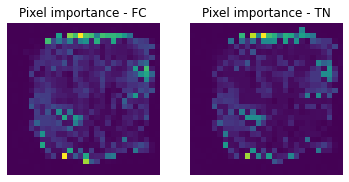

In [31]:
# Plot feature importances
import numpy as np
fig = plt.figure()
ax = fig.add_subplot(121)
ax.imshow(np.reshape(imp_fc, (28,28)))
ax.axis('off')
ax.set_title('Pixel importance - FC')
ax = fig.add_subplot(122)
ax.imshow(np.reshape(imp_tn, (28,28)))
ax.axis('off')
ax.set_title('Pixel importance - TN')
plt.savefig('MNIST_importance.png')

In [18]:
from tf_lassonet.graphics import plot_history

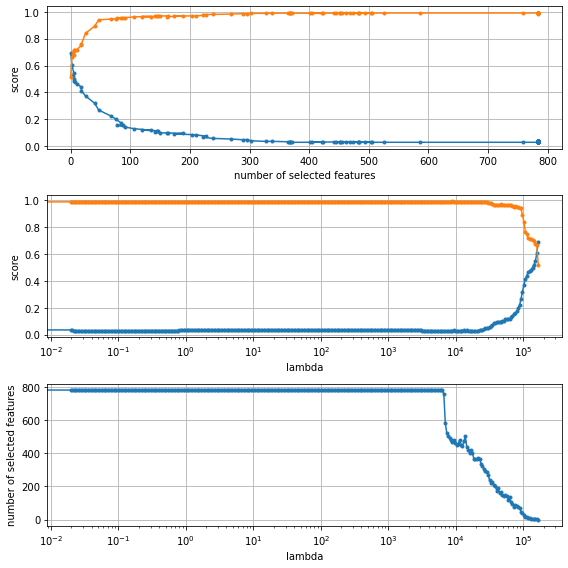

In [26]:
plot_history(h_fc)

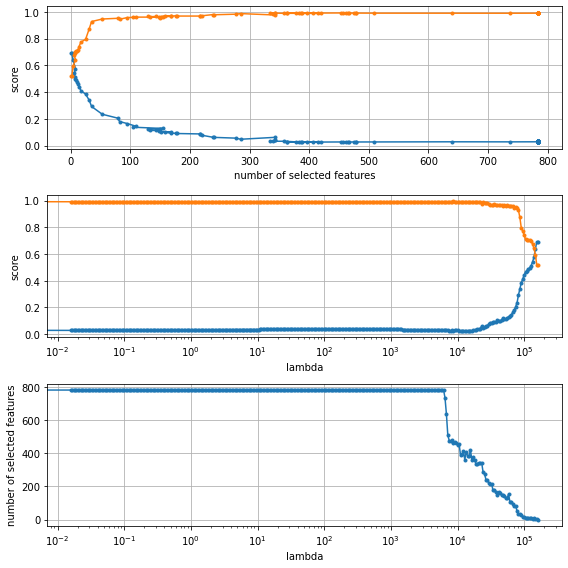

In [19]:
plot_history(h_tn)